# Default model parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from scipy.spatial.transform import Rotation

from e3nn import o3

from mace import data, modules, tools
from mace.tools import torch_geometric

import ase.io
from ase.visualize import view

In [2]:
import warnings
warnings.filterwarnings('ignore')
torch.set_default_dtype(torch.float32)

In [3]:
z_table = tools.AtomicNumberTable([1,6,8])
atomic_energies = np.array([-1.0, -3.0, -5.0], dtype=np.float32)
cutoff = 3

default_model_config = dict(num_elements = 3,
    atomic_energies = atomic_energies,
    avg_num_neighbors = 8,
    atomic_numbers = z_table.zs,
    r_max = cutoff,
    num_bessel = 8,
    num_polynomial_cutoff = 6,
    max_ell = 2,
    num_interactions =2,
    interaction_cls_first = modules.interaction_classes["RealAgnosticResidualInteractionBlock"],
    interaction_cls = modules.interaction_classes["RealAgnosticResidualInteractionBlock"],
    hidden_irreps = o3.Irreps("8x0e + 8x1o"),
    correlation = 3,
    MLP_irreps = o3.Irreps("16x0e"),
    gate = torch.nn.functional.silu,
)

default_model = modules.MACE(**default_model_config)

# Spherical Tensors

In [4]:
# l= 0,1,2 therefore, 0=1, 1=(2*1)+1=3, 2=2*2+1=5, 1+3+5=9 
spherical_harmonics = o3.SphericalHarmonics([0,1,2], normalize=True)

v = torch.tensor([1,0.2,0.75])
print(spherical_harmonics(v))

tensor([ 0.2821,  0.3860,  0.0772,  0.2895,  0.5113,  0.1364, -0.2918,  0.1023,
        -0.1491])


Why is the array 9 elements long? We calculated the $l=0,1,2$ for all valid $m's$, and stored them in this format: $$[Y_0^0, \ \ Y_{1}^{-1}, Y_{1}^{0},Y_{1}^{1}, \ \ Y_{2}^{-2}, Y_{2}^{-1}, Y_{2}^{0}, Y_{2}^{1}, Y_{2}^{2}, ]$$

$$Y^m_l$$

Which has 9 elements in total. Generally, this is how most arrays are stored in MACE. The final dimesion of the array combines the $l$ and $m$ indicices, and concatenates the values like this.

How do these transform under rotations? We can simply rotate the vector and get an idea for what happens by plotting the result:

shape of rotated v: torch.Size([360, 3])
shape of spherical harmonics values: torch.Size([360, 9])


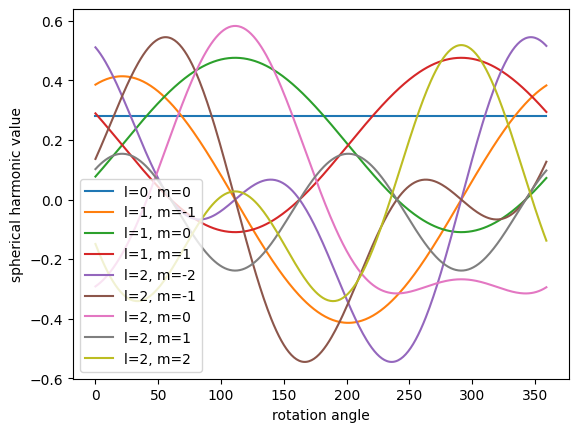

In [14]:
rotated_v = []
v = np.array([1,0.2,0.75])
N = 360
for i in range(N):
    rotation_matrix = Rotation.from_rotvec(i*2*np.pi*np.array([0,0.7071,0.7071])/360).as_matrix()
    rotated_v.append(rotation_matrix@v)

rotated_v = torch.tensor(rotated_v, dtype=torch.float32)

spherical_harmonic_values = spherical_harmonics(rotated_v)
print(f"shape of rotated v: {rotated_v.shape}")
print(f"shape of spherical harmonics values: {spherical_harmonic_values.shape}")

# plot
labels = [[f'l={l}, m={m}' for m in range(-l,l+1)] for l in range(3)]
labels = [x for xs in labels for x in xs] # flatten
plt.plot(spherical_harmonic_values.numpy(), label=labels)
plt.legend()
plt.xlabel('rotation angle')
plt.ylabel('spherical harmonic value')
plt.show()

# Getting invariant quantities with e3nn

In [20]:
np.random.seed(0)
vector1 = np.random.randn(3)
vector1 = vector1 / np.linalg.norm(vector1)
vector2 = np.random.randn(3)
vector2 = vector2 / np.linalg.norm(vector2)

spherical_harmonics_1 = spherical_harmonics(torch.tensor(vector1))
spherical_harmonics_2 = spherical_harmonics(torch.tensor(vector2))

print(f'l=0 component for vector {vector1}:', spherical_harmonics_1[0])
print(f'l=0 component for vector {vector2}:', spherical_harmonics_2[0])

l=0 component for vector [0.85771824 0.1945646  0.47588238]: tensor(0.2821, dtype=torch.float64)
l=0 component for vector [ 0.72840603  0.6070528  -0.31766579]: tensor(0.2821, dtype=torch.float64)


This isn't very useful, because the $l=0$ piece doesn't contain any angular information for either vector, so we have no way to know, for instance, the angle between them.

You can test this by changing one or both of the vectors (via the numpy seed). The $l=0$ piece won't change.

### How do we get Invariants which describe angular information?

To get a more descriptive invariant quantity, we need to do some operations on the spherical harmoincs. We care about how spherical harmonics change when you rotate the input, because its easy to keep track of how rotation affects things. This means that its easy to get back to an invariant quantity when we need to. In MACE, and many other MLIPs, this maths is done by a package called `e3nn`.

`e3nn` provides functions which perform operations on spherical tensors (things with elements like $[Y_{0}^0, Y_{1}^{-1}, Y_{1}^0, ...]$), while keeping track of the rotations. One example operation is a tensor product, which takes two arrays, $A_{lm}$ and $B_{lm}$, and multiplies them to give $C_{lm}$:

$$[A_{lm}] \ \otimes \ [B_{lm}] \ = \ [C_{lm}]$$

The key is that $C$ is still indexed by $l$ and $m$, so if we look at the $l=0$ piece, it will still be invariant! This means we can do a load of operations to combine spherical harmonics, and then create invariant descrpitors which know about things like angles ebtween vectors.

We can demonstrate this by the two vectors above, doing the tensor product of them, and keeping all the outputs which are invariant to rotations.

FullyConnectedTensorProduct(1x0e+1x1o+1x2e x 1x0e+1x1o+1x2e -> 3x0e | 9 paths | 9 weights)


(<Figure size 640x480 with 1 Axes>, <Axes: >)

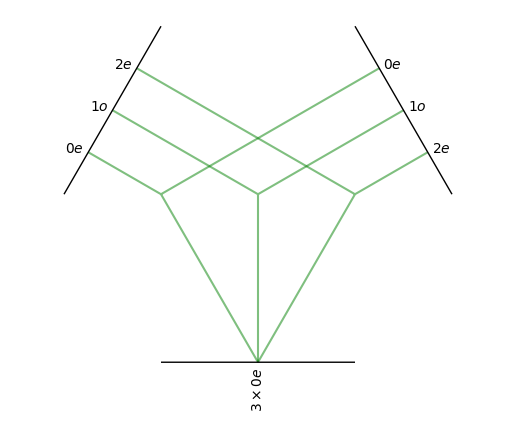

In [38]:
# set up tensor product
# this does product of two l=0,1,2 arrays and maps the results into three l=0 values

tensor_product = o3.FullyConnectedTensorProduct(
    irreps_in1=o3.Irreps("1x0e + 1x1o + 1x2e"),
    irreps_in2=o3.Irreps("1x0e + 1x1o + 1x2e"),
    irreps_out=o3.Irreps("3x0e"),
    internal_weights=False
)
print(tensor_product)
tensor_product.visualize()

In [39]:
print(spherical_harmonics_1)
print(spherical_harmonics_2)


tensor([ 0.2821,  0.4191,  0.0951,  0.2325,  0.4459,  0.1823, -0.2796,  0.1012,
        -0.2782], dtype=torch.float64)
tensor([ 0.2821,  0.3559,  0.2966, -0.1552, -0.2528,  0.4831,  0.0333, -0.2107,
        -0.2347], dtype=torch.float64)


In [42]:
# product the arrays
product = tensor_product(
    spherical_harmonics_1.unsqueeze(0),
    spherical_harmonics_2.unsqueeze(0),
    weight=torch.arange(1,10,1,dtype=torch.float64) # the product has weights which can be trained - for now I have fixed them
)
print('invariant outputs:', product)

invariant outputs: tensor([[0.2524, 0.3480, 0.4436]], dtype=torch.float64)


In [45]:
angle = 77.7 # degrees
rotation_matrix = Rotation.from_rotvec(angle * 2*np.pi * np.array([0, 0.7071, 0.7071])/360).as_matrix()

rotated_vec1 = rotation_matrix @ vector1
rotated_vec2 = rotation_matrix @ vector2

# get the spherical harmpnics
spherical_harmonics_1 = spherical_harmonics(torch.from_numpy(rotated_vec1))
spherical_harmonics_2 = spherical_harmonics(torch.from_numpy(rotated_vec2))

product = tensor_product(
    spherical_harmonics_1.unsqueeze(0),
    spherical_harmonics_2.unsqueeze(0),
    weight=torch.arange(1,10,dtype=torch.float64) # the product has weights which can be trained - for now I have fixed them
)
print('invariant outputs:', product)

invariant outputs: tensor([[0.2524, 0.3480, 0.4436]], dtype=torch.float64)


In [46]:
angle = 77.7 # degrees
rotation_matrix = Rotation.from_rotvec(angle * 2*np.pi * np.array([0, 0.7071, 0.7071])/360).as_matrix()

rotated_vec1 = rotation_matrix @ vector1
rotated_vec2 = vector2

# get the spherical harmpnics
spherical_harmonics_1 = spherical_harmonics(torch.from_numpy(rotated_vec1))
spherical_harmonics_2 = spherical_harmonics(torch.from_numpy(rotated_vec2))

product = tensor_product(
    spherical_harmonics_1.unsqueeze(0),
    spherical_harmonics_2.unsqueeze(0),
    weight=torch.arange(1,10,dtype=torch.float64) # the product has weights which can be trained - for now I have fixed them
)
print('invariant outputs:', product)

invariant outputs: tensor([[0.8285, 1.0166, 1.2048]], dtype=torch.float64)


You can see that the values are the same as before the rotation, but if you go back and change the seed used for creating the two vectors, they will be different. This meas that we have have made invariant quantities which can tell two pairs of unit vectors apart.

These kind of operations are what MACE is built on.

# MACE Feature Construction

We can now go through some key parts of the feature construction and look at the internal variables. The schematic at the top of the document has a full overview, and the key bits will be repeated.

## 0. Data Prep

The first step in MACE is to take the atomic structure and represent it as a list of atoms and 'edges'. An edge is simply a connection between two atoms. The cutoff radius of the MACE layer determines which atoms are connected by an edge.

Below we load a list of molecule, and show how the atoms and edges are stored.

In [47]:
single_molecule = ase.io.read('data/solvent_rotated.xyz', index='0')

Rcut = 3.0 # cutoff radius
z_table = tools.AtomicNumberTable([1, 6, 8])

config = data.Configuration(
    atomic_numbers=single_molecule.numbers,
    positions=single_molecule.positions
)

# we handle configurations using the AtomicData class
batch = data.AtomicData.from_config(config, z_table=z_table, cutoff=Rcut)
print("positions:", batch.positions)
print("node_attrs:", batch.node_attrs)
print("edge_index:", batch.edge_index)

positions: tensor([[-0.0635,  0.0262,  0.0327],
        [-1.0975, -0.5617, -0.3338],
        [ 0.5934,  0.0418,  1.1689],
        [ 0.7073,  0.5805, -0.9280],
        [-0.1848, -0.3831,  2.2763],
        [ 0.1179,  0.3132, -2.1891],
        [ 0.5008, -0.5289,  3.1636],
        [-0.9913,  0.3712,  2.5703],
        [-0.7990, -1.1969,  1.9391],
        [ 0.8217,  0.3929, -3.0412],
        [-0.5198, -0.6345, -2.2321],
        [-0.6849,  1.1558, -2.3539]])
node_attrs: tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])
edge_index: tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,
          2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
          4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  7,  8,  8,
          8,

In [100]:
help(single_molecule)

Help on Atoms in module ase.atoms object:

class Atoms(builtins.object)
 |  Atoms(symbols=None, positions=None, numbers=None, tags=None, momenta=None, masses=None, magmoms=None, charges=None, scaled_positions=None, cell=None, pbc=None, celldisp=None, constraint=None, calculator=None, info=None, velocities=None)
 |  
 |  Atoms object.
 |  
 |  The Atoms object can represent an isolated molecule, or a
 |  periodically repeated structure.  It has a unit cell and
 |  there may be periodic boundary conditions along any of the three
 |  unit cell axes.
 |  Information about the atoms (atomic numbers and position) is
 |  stored in ndarrays.  Optionally, there can be information about
 |  tags, momenta, masses, magnetic moments and charges.
 |  
 |  In order to calculate energies, forces and stresses, a calculator
 |  object has to attached to the atoms object.
 |  
 |  Parameters:
 |  
 |  symbols: str (formula) or list of str
 |      Can be a string formula, a list of symbols or a list of
 |

In [60]:
batch.keys

['edge_index',
 'positions',
 'shifts',
 'unit_shifts',
 'cell',
 'node_attrs',
 'weight',
 'head',
 'energy_weight',
 'forces_weight',
 'stress_weight',
 'virials_weight']

The `node_attrs` describe the species. `[1,0,0]` means the first kind of element, `[0,1,0]` means the second kind, and so on.

In this case we told MACE to work with Hydrogen, Carbon and Oxygen with the line `z_table = ...`.

The 'edges' are stored by a list of 'senders' and 'receievers', which represent the start and end point of each edge.

We can now compute the lengths and directions of each edge:

In [48]:
vectors, lengths = modules.utils.get_edge_vectors_and_lengths(
    positions=batch["positions"],
    edge_index=batch["edge_index"],
    shifts=batch["shifts"],
)
print(f'there are {batch.positions.shape[0]} nodes and {len(lengths)} edges')
print(f'lengths is shape {lengths.shape}')
print(f'vectors is shape {vectors.shape}')

there are 12 nodes and 74 edges
lengths is shape torch.Size([74, 1])
vectors is shape torch.Size([74, 3])


In [55]:
lengths[0]

tensor([1.2446])

In [54]:
torch.linalg.norm(vectors[0], ord=2)

tensor(1.2446)

In [101]:
o3.Irreps([(3,(0,1))])

3x0e

In [105]:
hidden_irreps = o3.Irreps("2x0e + 15x1o")
o3.Irreps([(hidden_irreps.count(o3.Irrep(0, 1)), (0, 1))])

2x0e

In [130]:
rep = o3.Irreps("1x0e+1x1o")
x = torch.rand(rep.dim)
print(x)
rep.index(x)

tensor([0.9393, 0.5581, 0.7967, 0.6046])


NotImplementedError: 

In [124]:
o3.Irreps("2x0e").dim

2

In [127]:
o3.Linear("1x1e","1x0e")

Linear(1x1e -> 1x0e | 0 weights)


## 1. Embeddings

We now take this information and make the initial inputs to the MACE model. This is called the embedding.

#### Key concept: MACE 'channels'

The equation for the initial node features looks like this:
$$h_{i,k00}^{(0)} = \sum_z W_{kz} \delta_{zz_{i}}$$
Take the exmaple where all atoms are either hydrogen or carbon. If atom $i$ is hydrogen, the its initial node features are just $W_{k0}$. If atom $n$ is carbon it will get initial features $W_{k1}$. This means that each atom is given a vector of length $K$, based on its chemical species.

```In mace, the range of k is referred to as the number of 'channels'. This is the fundamental 'size' of the descriptor```
the figure at the top of the notebook sort of shows this.

This operation of giving each atom a length-K vector depending on its species is called the node 'embedding'.

We also 'embed' the lengths and directions of the edges. The lengths of the edges are mapped through a set of 8 bessel functions, and for the dircetion of the edge we just calculate the spherical harmoincs.

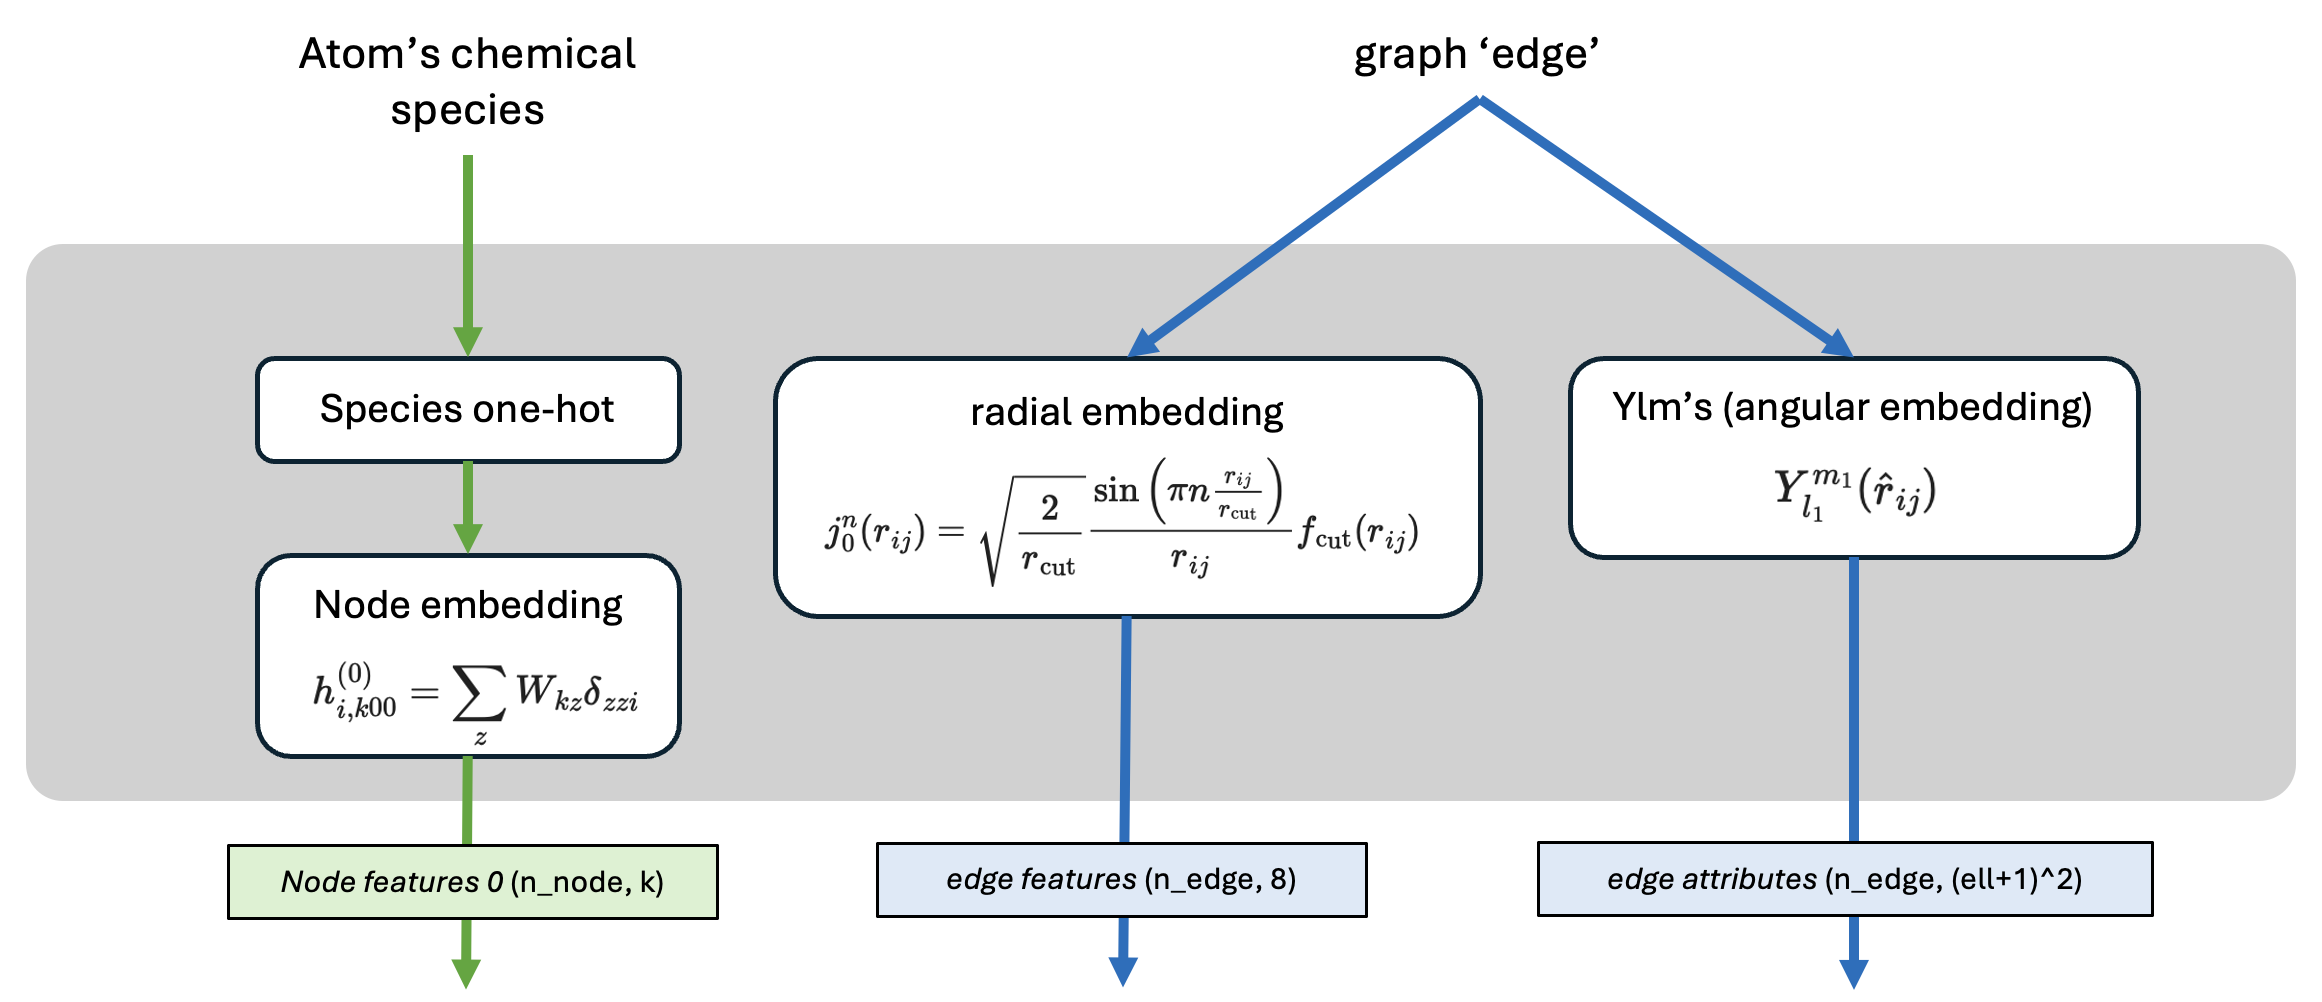

In [49]:
default_model_config

{'num_elements': 3,
 'atomic_energies': array([-1., -3., -5.], dtype=float32),
 'avg_num_neighbors': 8,
 'atomic_numbers': [1, 6, 8],
 'r_max': 3,
 'num_bessel': 8,
 'num_polynomial_cutoff': 6,
 'max_ell': 2,
 'num_interactions': 2,
 'interaction_cls_first': mace.modules.blocks.RealAgnosticResidualInteractionBlock,
 'interaction_cls': mace.modules.blocks.RealAgnosticResidualInteractionBlock,
 'hidden_irreps': 8x0e+8x1o,
 'correlation': 3,
 'MLP_irreps': 16x0e,
 'gate': <function torch.nn.functional.silu(input: torch.Tensor, inplace: bool = False) -> torch.Tensor>}

In [56]:
model

MACE(
  (node_embedding): LinearNodeEmbeddingBlock(
    (linear): Linear(3x0e -> 8x0e | 24 weights)
  )
  (radial_embedding): RadialEmbeddingBlock(
    (bessel_fn): BesselBasis(r_max=3.0, num_basis=8, trainable=False)
    (cutoff_fn): PolynomialCutoff(p=6.0, r_max=3.0)
  )
  (spherical_harmonics): SphericalHarmonics()
  (atomic_energies_fn): AtomicEnergiesBlock(energies=[[-1.0000, -3.0000, -5.0000]])
  (interactions): ModuleList(
    (0): RealAgnosticResidualInteractionBlock(
      (linear_up): Linear(8x0e -> 8x0e | 64 weights)
      (conv_tp): TensorProduct(8x0e x 1x0e+1x1o+1x2e -> 8x0e+8x1o+8x2e | 24 paths | 24 weights)
      (conv_tp_weights): FullyConnectedNet[8, 64, 64, 64, 24]
      (linear): Linear(8x0e+8x1o+8x2e -> 8x0e+8x1o+8x2e | 192 weights)
      (skip_tp): FullyConnectedTensorProduct(8x0e x 3x0e -> 8x0e+8x1o | 192 paths | 192 weights)
      (reshape): reshape_irreps()
    )
    (1): RealAgnosticResidualInteractionBlock(
      (linear_up): Linear(8x0e+8x1o -> 8x0e+8x1o | 12

In [50]:
# set up a mace model to get all of the blocks in one place:
model = modules.MACE(**default_model_config)

initial_node_features = model.node_embedding(batch.node_attrs)
edge_features = model.radial_embedding(lengths, batch["node_attrs"], batch["edge_index"], z_table)
edge_attributes = model.spherical_harmonics(vectors)

print('initial_node_features is (num_atoms, num_channels):', initial_node_features.shape)
print('edge_features is (num_edge, num_bessel_func):', edge_features.shape)
print('edge_attributes is (num_edge, dimension of spherical harmonics):', edge_attributes.shape)
print(
    '\nInitial node features. Note that they are the same for each chemical element\n',
    initial_node_features
)

initial_node_features is (num_atoms, num_channels): torch.Size([12, 8])
edge_features is (num_edge, num_bessel_func): torch.Size([74, 8])
edge_attributes is (num_edge, dimension of spherical harmonics): torch.Size([74, 9])

Initial node features. Note that they are the same for each chemical element
 tensor([[ 1.5227, -0.1209, -0.1413, -0.2751, -0.0092, -0.1653,  0.0339,  0.4032],
        [ 1.1126, -0.5687,  0.1689,  0.5272,  0.2651,  0.4037,  0.3655, -0.6271],
        [ 1.1126, -0.5687,  0.1689,  0.5272,  0.2651,  0.4037,  0.3655, -0.6271],
        [ 1.1126, -0.5687,  0.1689,  0.5272,  0.2651,  0.4037,  0.3655, -0.6271],
        [ 1.5227, -0.1209, -0.1413, -0.2751, -0.0092, -0.1653,  0.0339,  0.4032],
        [ 1.5227, -0.1209, -0.1413, -0.2751, -0.0092, -0.1653,  0.0339,  0.4032],
        [-0.4439, -0.8789,  0.2046,  0.6514, -0.9211, -0.6512,  0.1696,  0.3141],
        [-0.4439, -0.8789,  0.2046,  0.6514, -0.9211, -0.6512,  0.1696,  0.3141],
        [-0.4439, -0.8789,  0.2046,  0.651

dists.shape: torch.Size([100, 1])
radials.shape: torch.Size([100, 8])


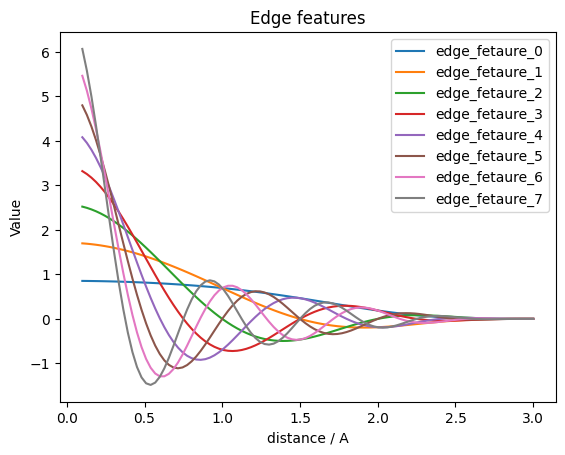

In [57]:
# we can plot what the 'edge feature' look like as a function of edge length
dists = torch.tensor(np.linspace(0.1,cutoff,100), dtype=torch.get_default_dtype()).unsqueeze(-1)
print("dists.shape:", dists.shape)

radials = model.radial_embedding(dists, batch["node_attrs"], batch["edge_index"], z_table)
print(f"radials.shape: {radials.shape}")
for i in range(radials.shape[1]):
    plt.plot(dists, radials[:,i], label=f"edge_fetaure_{i}")

# Add title, labels, and legend
plt.title("Edge features")
plt.xlabel("distance / A")
plt.ylabel("Value")
plt.legend()

# Display the plot
plt.show()

The parameter `max_ell` in the mace config (top of file) controls the maximum $l$ in the spherical harmonics, and hence the dimension of the `edge_attributes`.

The intial node features are invariant, and depend only on the speices. You can check this by printing them and comparing to `batch.node_attrs`.

The edge features are invariant because they only depend on length, and the edge attributes are of course spherical harmonics, and change as things rotate.

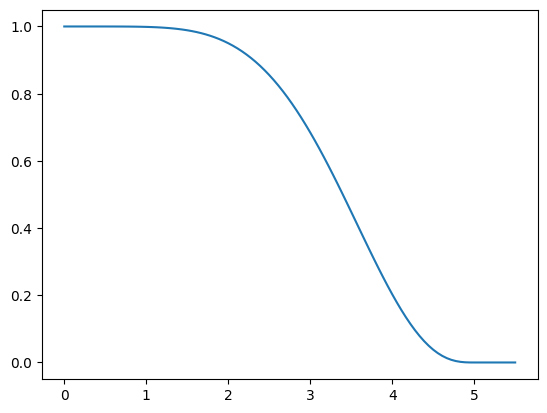

In [133]:
polynomial_cutoff = modules.PolynomialCutoff(r_max=5.0, p=6)
x = torch.tensor(np.linspace(0,5.5,100), dtype=torch.get_default_dtype())
y = polynomial_cutoff(x)

plt.plot(x,y)

In [135]:
sh_irreps = o3.Irreps.spherical_harmonics(2)
print("sh_irreps: ",sh_irreps)
hidden_irreps = o3.Irreps("4x0e + 4x1o")
num_features = hidden_irreps.count(o3.Irrep(0, 1))
print(f"num_features: {num_features}")
print(f"sh_irreps * num_features: {sh_irreps * num_features}")
print(f"sh_irreps * num_features.sort(): {(sh_irreps * num_features).sort()}")
interaction_irreps = (sh_irreps * num_features).sort()[0].simplify()
interaction_irreps


sh_irreps:  1x0e+1x1o+1x2e
num_features: 4
sh_irreps * num_features: 1x0e+1x1o+1x2e+1x0e+1x1o+1x2e+1x0e+1x1o+1x2e+1x0e+1x1o+1x2e
sh_irreps * num_features.sort(): sort(irreps=1x0e+1x0e+1x0e+1x0e+1x1o+1x1o+1x1o+1x1o+1x2e+1x2e+1x2e+1x2e, p=(0, 4, 8, 1, 5, 9, 2, 6, 10, 3, 7, 11), inv=(0, 3, 6, 9, 1, 4, 7, 10, 2, 5, 8, 11))


4x0e+4x1o+4x2e

In [139]:
spherical_harmonics = o3.SphericalHarmonics(
            sh_irreps, normalize=True, normalization="component"
        )
v= torch.rand(3)
spherical_harmonics(v/torch.norm(v,2))

tensor([ 1.0000,  1.0679,  1.3596,  0.1053,  0.1451,  1.8744,  0.9488,  0.1848,
        -0.7289])

In [140]:
v= torch.rand(3)
spherical_harmonics(v/torch.norm(v,2))

tensor([ 1.0000,  1.3346,  0.5812,  0.9387,  1.6174,  1.0013, -0.7404,  0.7043,
        -0.5808])


## 2. Interaction

Having created the intial features, the fun begins. The interaction block is tasked with pooling information over neighbours while tracking the properties of all arrays with $(l,m)$ indices. The output is a set of atomic features which contain information about the neighbours but are still 2-body.

The figure below shows all the equations of the interaction which is used in the first layer. In the second layer of mace, the interaction step is significantly more complex - the end of this notebook discusses this if you are interested.

The first layer of MACE is actually very similar to the simpler, and related, ACE model. We won't go through the internals of the interaction, but its at the end of the notebook if you are interested.

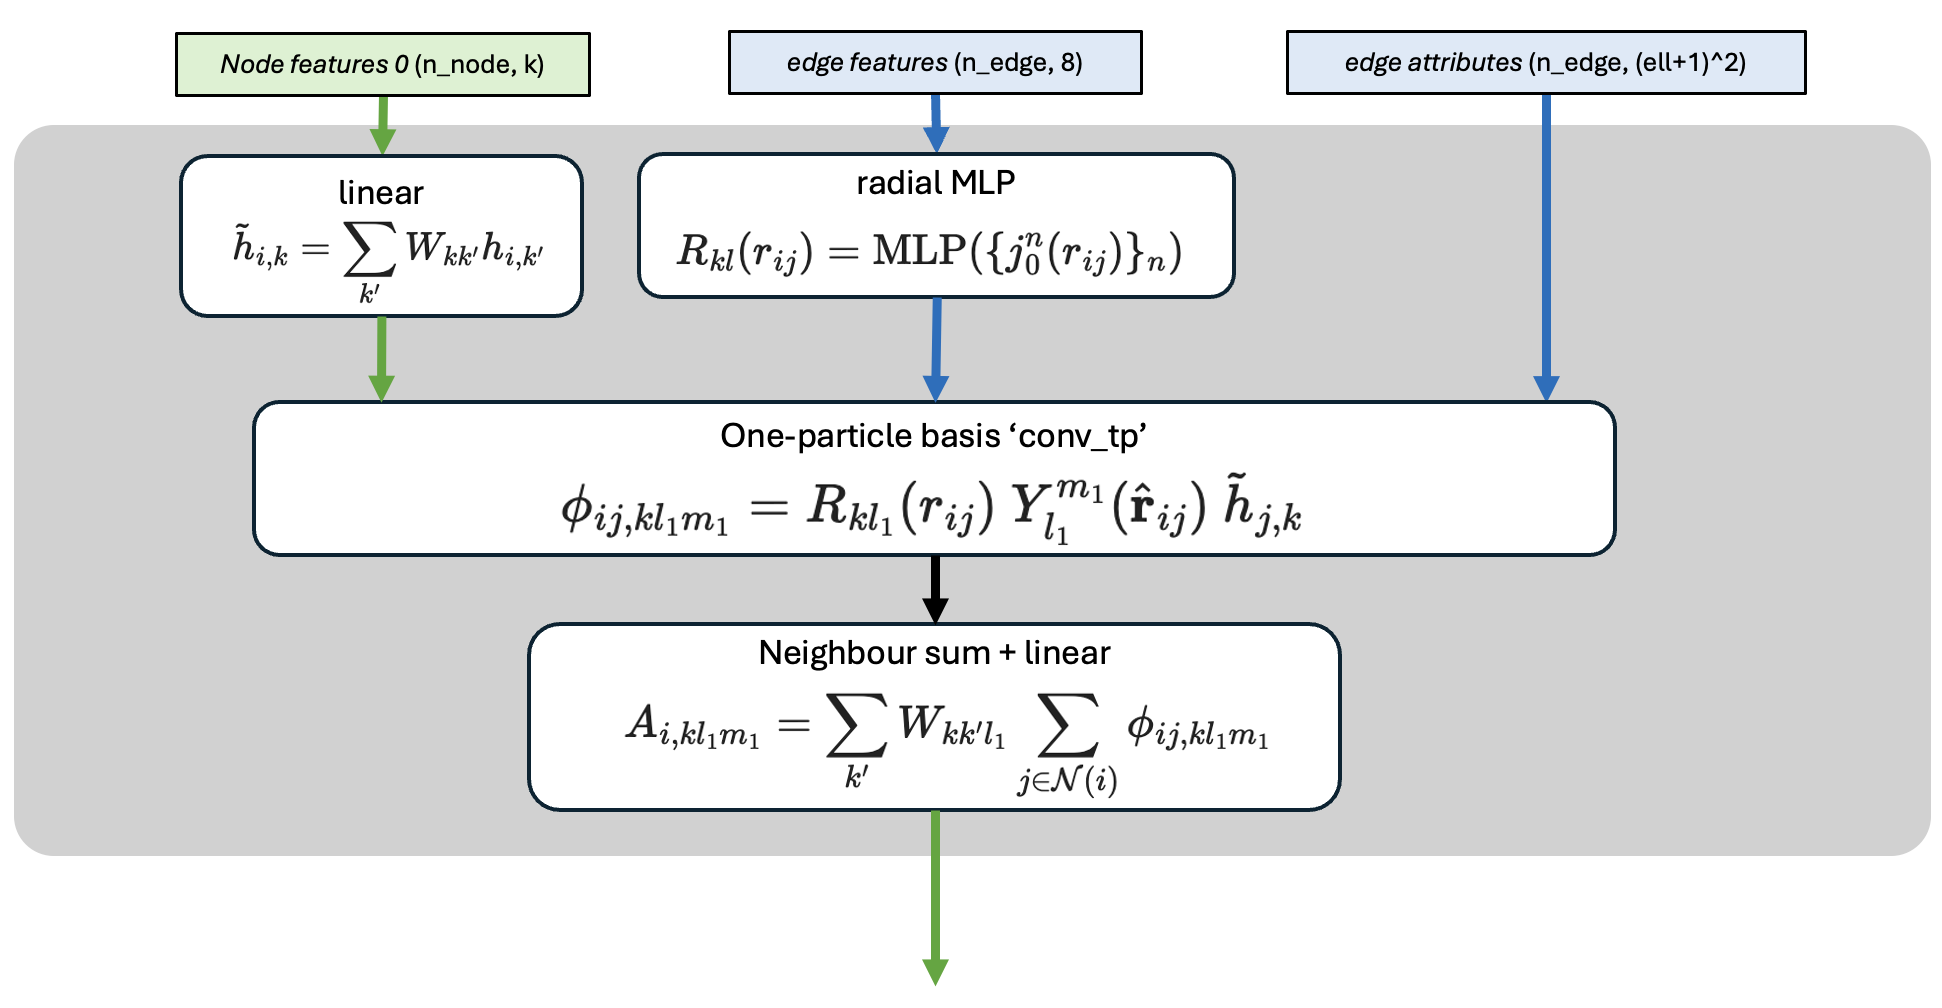

In [61]:
model.interactions

ModuleList(
  (0): RealAgnosticResidualInteractionBlock(
    (linear_up): Linear(8x0e -> 8x0e | 64 weights)
    (conv_tp): TensorProduct(8x0e x 1x0e+1x1o+1x2e -> 8x0e+8x1o+8x2e | 24 paths | 24 weights)
    (conv_tp_weights): FullyConnectedNet[8, 64, 64, 64, 24]
    (linear): Linear(8x0e+8x1o+8x2e -> 8x0e+8x1o+8x2e | 192 weights)
    (skip_tp): FullyConnectedTensorProduct(8x0e x 3x0e -> 8x0e+8x1o | 192 paths | 192 weights)
    (reshape): reshape_irreps()
  )
  (1): RealAgnosticResidualInteractionBlock(
    (linear_up): Linear(8x0e+8x1o -> 8x0e+8x1o | 128 weights)
    (conv_tp): TensorProduct(8x0e+8x1o x 1x0e+1x1o+1x2e -> 16x0e+24x1o+16x2e | 56 paths | 56 weights)
    (conv_tp_weights): FullyConnectedNet[8, 64, 64, 64, 56]
    (linear): Linear(16x0e+24x1o+16x2e -> 8x0e+8x1o+8x2e | 448 weights)
    (skip_tp): FullyConnectedTensorProduct(8x0e+8x1o x 3x0e -> 8x0e | 192 paths | 192 weights)
    (reshape): reshape_irreps()
  )
)

In [62]:
Interaction = model.interactions[0]

intermediate_node_features, sc = Interaction(
    node_feats=initial_node_features,
    node_attrs=batch.node_attrs,
    edge_feats=edge_features,
    edge_attrs=edge_attributes,
    edge_index=batch.edge_index,
)

print("the output of the interaction is (num_atoms, channels, dim. spherical harmonics):", intermediate_node_features.shape)

the output of the interaction is (num_atoms, channels, dim. spherical harmonics): torch.Size([12, 8, 9])


One important part of the interaction is how the `edge_attrs` (the bessel function values) enter.

The bessel function values are mapped through a multilayer perceptron ('radial MLP') to make a large number of learnable functions of edge length. The output is sometimes called a 'learnable raidal basis' $R_{kl}(r_{ij})$ - one radial function for each $(k,l)$ combination.

These learnable functions are then combined with the spherical harmonics of the $j\rightarrow i$ edge, and the initial node features of the neighbouring atom ($j$). The result is that $\phi_{ij,klm}(\mathbf{r}_{ij})$ is quite a rich set of descriptors of the $j$'th neighbour atom.

We can plot some of these radial functions to see how kind of shapes they have.

the output of the radial MLP is (num_dists, num_weights): (100, 24)


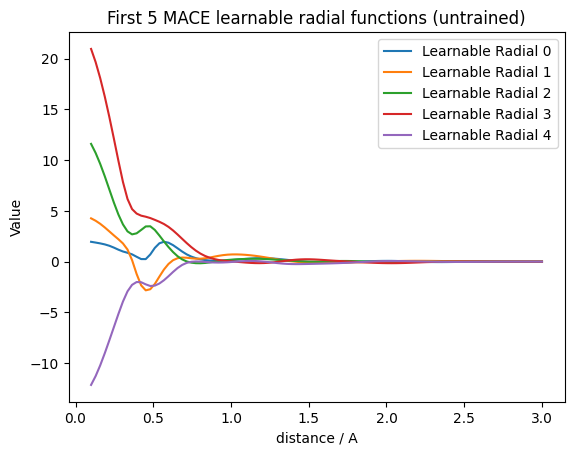

In [63]:
# visulaise what the radial MLP does
dists = torch.tensor(np.linspace(0.1, cutoff, 100), dtype=torch.get_default_dtype()).unsqueeze(-1)

# first do radial embedding again
edge_feats_scan = model.radial_embedding(dists, batch["node_attrs"], batch["edge_index"], model.atomic_numbers)

# put the edge feats into the radial MLP
tp_weights_scan = model.interactions[0].conv_tp_weights(edge_feats_scan).detach().numpy()
print('the output of the radial MLP is (num_dists, num_weights):', tp_weights_scan.shape)

# plot the outputs
num_basis_to_print = 5
for i in range(num_basis_to_print):
    plt.plot(dists, tp_weights_scan[:, i], label=f'Learnable Radial {i}')

# Add title, labels, and legend
plt.title(f"First {num_basis_to_print} MACE learnable radial functions (untrained)")
plt.xlabel("distance / A")
plt.ylabel("Value")
plt.legend()

# Display the plot
plt.show()


## 3. Product

The key operation of MACE is the efficient construction of higher order features from the ${A}_{i}^{(t)}$-features (the output of the interaction).
This is achieved by first forming tensor products of the features, and then symmetrising, as shown in the figure. This operation:
$$
{B}^{(t)}_{i,\eta_{\nu} k LM}
= \sum_{{l}{m}} \mathcal{C}^{LM}_{\eta_{\nu}, l m} \prod_{\xi = 1}^{\nu} A_{i,k l_\xi  m_\xi}^{(t)}
$$
is essentially doing $A_{lm} \otimes A_{lm} \otimes ...$ and eventually getting back to something which transforms in a known way - ${B}^{(t)}_{i,\eta_{\nu} k LM}$. It happens on each node - all pooling between neighbours is done in the interction.

Like in the example above with two vectors, this product operation creates features which have angular information, but which are still invariant.

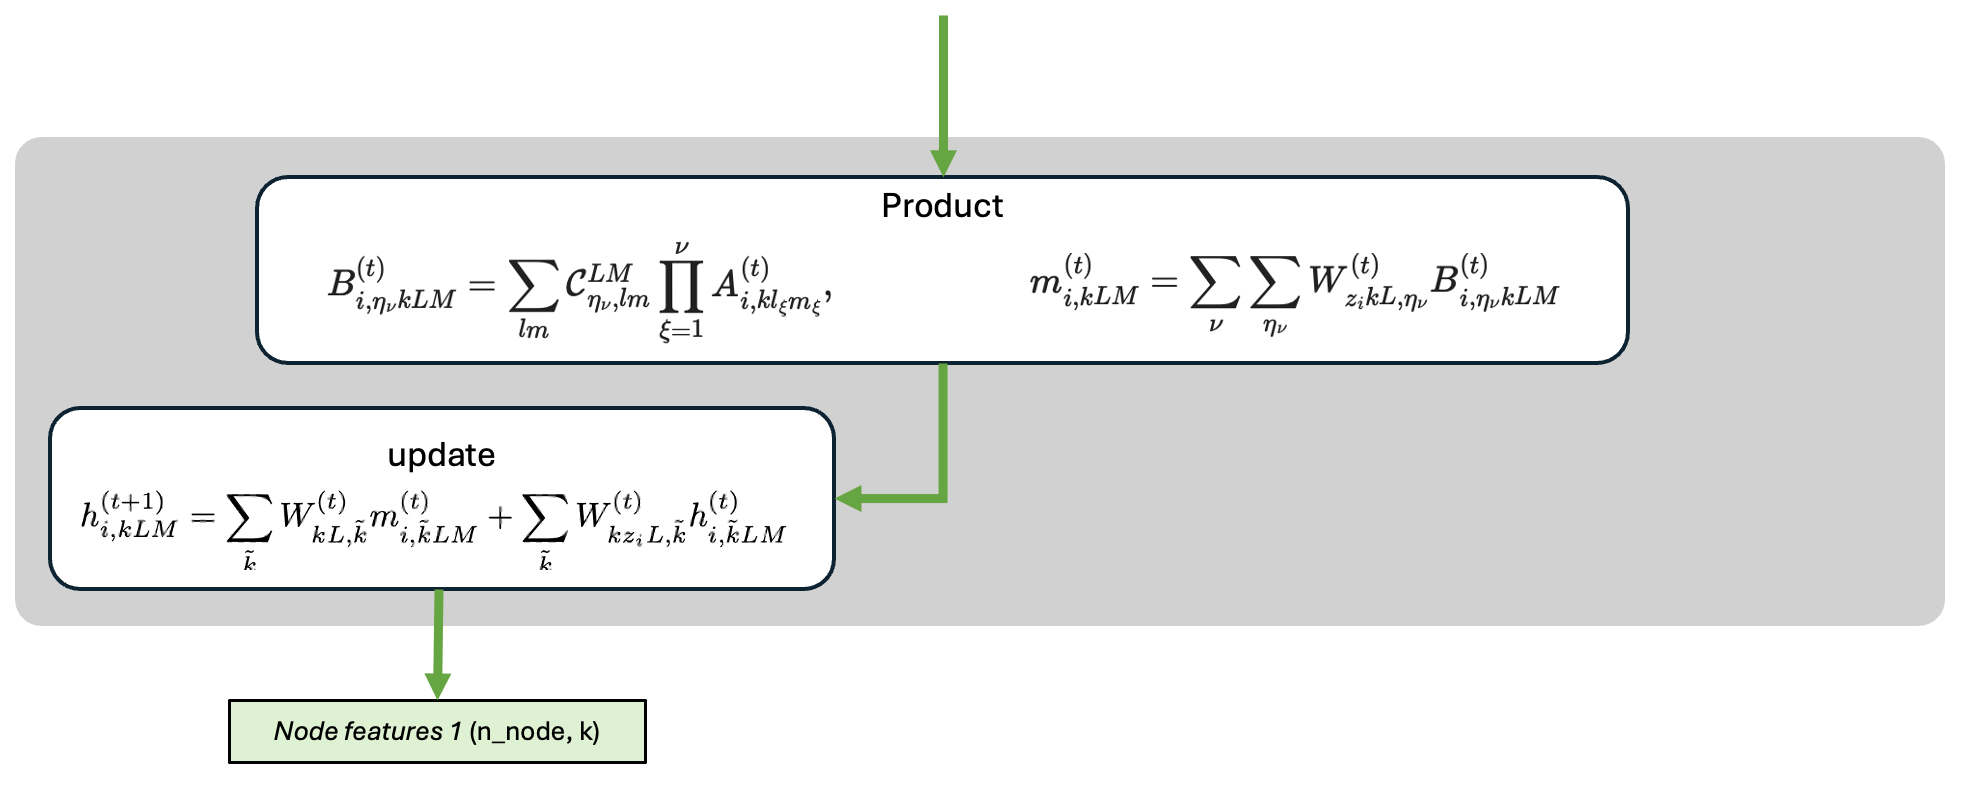

The final part of the product is to linearly mix everything together and create a new set of node features.

These node features don't have to be invariant. Its possible to retain some level of equivariance and then use this extra information in the second layer of MACE, where the whole interaction an product is repeated.

Whether to do this is controlled by the `max_L` parameter to MACE (see the model config). If this is set to 0, then only invariant features are retained. If it is set to 1 (which is the case here), the new node features will have $l=0$ and $l=1$ pieces.

In [64]:
new_node_features = model.products[0](
    node_feats=intermediate_node_features,
    node_attrs=batch.node_attrs,
    sc=sc,
)
print('new node feats are (num_atoms, (L+1)^2 * num_channels):', new_node_features.shape)

new node feats are (num_atoms, (L+1)^2 * num_channels): torch.Size([12, 32])


you should find that the array is (num_atoms, 32), since 32=8*4, where 4 is because we have $[Y_{00}, Y_{1,-1}, Y_{1,0}, Y_{1,1}]$ pieces, and 8 is because we have 8 'channels'.

You can check the equivariance of these features by modifying the above code to read a different config from `rotated_solvent.xyz`. This will be the same structure, but rotated. You should see that the first 32 elements are the same (since they are invariant) and the rest change.


## 4. Readout

Finally, we can take the new node features and create an actual energy. This is done by passing the node features through a `readout`.

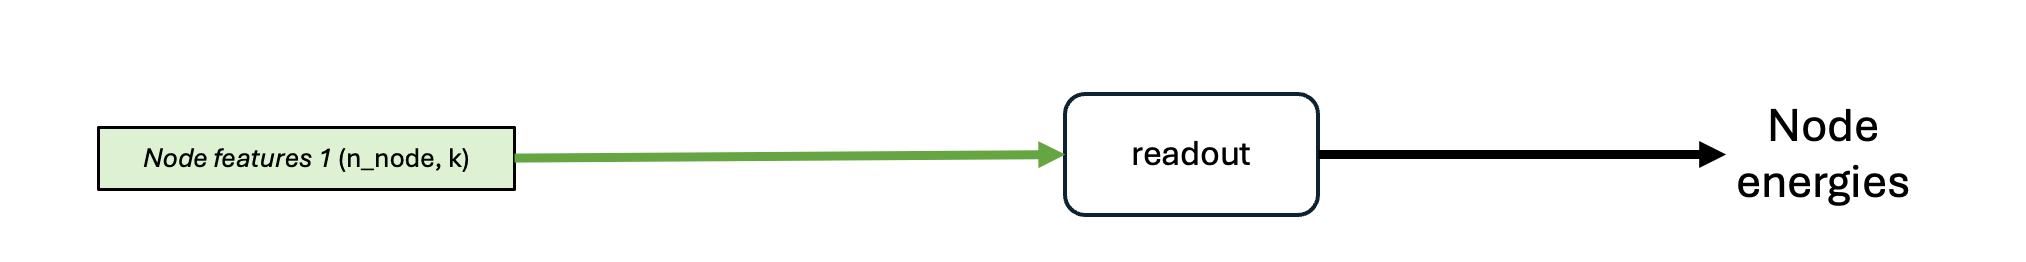

In an $S$-layer MACE, the readout from the features at layer $s$ is:

\begin{equation*}
    \mathcal{R}^{(s)} \left( \boldsymbol{h}_i^{(s)} \right) =
    \begin{cases}
      \sum_{k}W^{(s)}_{k}h^{(s)}_{i,k00}     & \text{if} \;\; 1 < s < S \\[13pt]
      {\rm MLP} \left( \left\{ h^{(s)}_{i,k00} \right\}_k \right)  &\text{if} \;\; s = S
    \end{cases}
\end{equation*}

In our example case this maps the 32 dimensional $h^{(1)}_{i,k00}$, the invariant part os the node features after the first interaction to the first term in the aotmic site energy:

In [67]:
print('first readout =', model.readouts[0], '\n')

energy_layer_1 = model.readouts[0](new_node_features)
print('energy_layer_1:', energy_layer_1.shape)
print(energy_layer_1)

first readout = LinearReadoutBlock(
  (linear): Linear(8x0e+8x1o -> 1x0e | 8 weights)
) 

energy_layer_1: torch.Size([12, 1])
tensor([[ 0.0356],
        [-0.0225],
        [ 0.0039],
        [ 0.0054],
        [ 0.0430],
        [ 0.0508],
        [ 0.4668],
        [ 0.4627],
        [ 0.4573],
        [ 0.4646],
        [ 0.4578],
        [ 0.4672]], grad_fn=<ViewBackward0>)


# MACE_dev

In [68]:
import numpy as np
import torch
import torch.nn.functional
from e3nn import o3
from matplotlib import pyplot as plt
%matplotlib inline

from mace import data, modules, tools
from mace.tools import torch_geometric

In [69]:
z_table = tools.AtomicNumberTable([1, 8])
atomic_energies = np.array([-1.0, -3.0], dtype=float)
cutoff = 3

model_config = dict(
        num_elements=2,  # number of chemical elements
        atomic_energies=atomic_energies,  # atomic energies used for normalisation
        avg_num_neighbors=8,  # avg number of neighbours of the atoms, used for internal normalisation of messages
        atomic_numbers=z_table.zs,  # atomic numbers, used to specify chemical element embeddings of the model
        r_max=cutoff,  # cutoff
        num_bessel=8,  # number of radial features
        num_polynomial_cutoff=6,  # smoothness of the radial cutoff
        max_ell=2,  # expansion order of spherical harmonic adge attributes
        num_interactions=2,  # number of layers, typically 2
        interaction_cls_first=modules.interaction_classes[
            "RealAgnosticResidualInteractionBlock"
        ],  # interation block of first layer
        interaction_cls=modules.interaction_classes[
            "RealAgnosticResidualInteractionBlock"
        ],  # interaction block of subsequent layers
        hidden_irreps=o3.Irreps("4x0e + 4x1o"),  # 4: number of embedding channels, 0e, 1o is specifying which equivariant messages to use. Here up to L_max=1
        correlation=3,  # correlation order of the messages (body order - 1)
        MLP_irreps=o3.Irreps("2x0e"),  # number of hidden dimensions of last layer readout MLP
        gate=torch.nn.functional.silu,  # nonlinearity used in last layer readout MLP
    )
model = modules.MACE(**model_config)

In [70]:
model

MACE(
  (node_embedding): LinearNodeEmbeddingBlock(
    (linear): Linear(2x0e -> 4x0e | 8 weights)
  )
  (radial_embedding): RadialEmbeddingBlock(
    (bessel_fn): BesselBasis(r_max=3.0, num_basis=8, trainable=False)
    (cutoff_fn): PolynomialCutoff(p=6.0, r_max=3.0)
  )
  (spherical_harmonics): SphericalHarmonics()
  (atomic_energies_fn): AtomicEnergiesBlock(energies=[[-1.0000, -3.0000]])
  (interactions): ModuleList(
    (0): RealAgnosticResidualInteractionBlock(
      (linear_up): Linear(4x0e -> 4x0e | 16 weights)
      (conv_tp): TensorProduct(4x0e x 1x0e+1x1o+1x2e -> 4x0e+4x1o+4x2e | 12 paths | 12 weights)
      (conv_tp_weights): FullyConnectedNet[8, 64, 64, 64, 12]
      (linear): Linear(4x0e+4x1o+4x2e -> 4x0e+4x1o+4x2e | 48 weights)
      (skip_tp): FullyConnectedTensorProduct(4x0e x 2x0e -> 4x0e+4x1o | 32 paths | 32 weights)
      (reshape): reshape_irreps()
    )
    (1): RealAgnosticResidualInteractionBlock(
      (linear_up): Linear(4x0e+4x1o -> 4x0e+4x1o | 32 weights)
   

In [71]:
# dummy water molecule
config = data.Configuration(
    atomic_numbers=np.array([8, 1, 1]),
    positions=np.array(
        [
            [0.0, -2.0, 0.0],
            [1.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
        ]
    ),
    forces=np.array(
        [
            [0.0, -1.3, 0.0],
            [1.0, 0.2, 0.0],
            [0.0, 1.1, 0.3],
        ]
    ),
    energy=-1.5,
)

atomic_data = data.AtomicData.from_config(config, z_table=z_table, cutoff=float(model.r_max))
data_loader = torch_geometric.dataloader.DataLoader(
        dataset=[atomic_data],
        batch_size=1,
        shuffle=True,
        drop_last=False,
    )
batch = next(iter(data_loader))
print("The data is stored in batches. Each batch is a single graph, potentially made up of several disjointed sub-graphs corresponding to different chemical structures. ")
print(batch)
print("\nbatch.edge_index contains which atoms are connected within the cutoff. It is the adjacency matrix in sparse format.\n")
print(batch.edge_index)

The data is stored in batches. Each batch is a single graph, potentially made up of several disjointed sub-graphs corresponding to different chemical structures. 
Batch(batch=[3], cell=[3, 3], edge_index=[2, 4], energy=[1], energy_weight=[1], forces=[3, 3], forces_weight=[1], head=[1], node_attrs=[3, 2], positions=[3, 3], ptr=[2], shifts=[4, 3], stress_weight=[1], unit_shifts=[4, 3], virials_weight=[1], weight=[1])

batch.edge_index contains which atoms are connected within the cutoff. It is the adjacency matrix in sparse format.

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])


### Spherical Harmonics
The real spherical harmonics expand the angular degree of freedom in a basis that are index by $lm$ indices. We describe the angular part as a unit vector $\hat{r}_{ij} := \frac{r_{i} - r_{j}}{||r_{i} - r_{j}||_{2}}$ and the spherical harmonics are defined as polynomial functions of $\hat{r}$ that are orthonormal.

Let's first create a random set of points on the unit sphere and plot them.

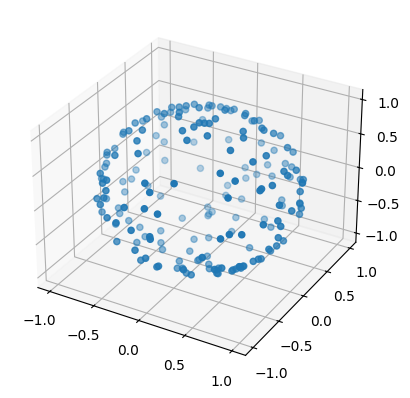

In [72]:
# create random set of points on the unit sphere and plot them
n = 200
points = torch.randn(n, 3)
points = points / points.norm(dim=-1, keepdim=True)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
plt.show()

The order of the expansion in controlled by $l_{\text{max}}$ and the number of basis functions is $(l_{\text{max}} + 1)^{2}$. Let's see what $l_{\text{max}}$ is used in this model.

In [73]:
l_max = model.spherical_harmonics._lmax
print("l_max =",l_max)

l_max = 2


One important aspect of spherical harmonics is their normalization. In MACE, we use the **component** normalization satisfying:
$$||Y_{l}||^{2} = 2l + 1$$
Let's pass now the points to the spherical harmonics and check the normalization and the shape.
In the model's code, the unit vectors expanded in the spherical harmonics basis are named **edge_attrs**.

In [74]:
edge_attrs = model.spherical_harmonics(points)
print("shape:", edge_attrs.shape)
print("number of edges:", edge_attrs.shape[0])
print("number of features: (2l + 1)^2=", edge_attrs.shape[1])

# Compute the norm of the different irreps of the spherical harmonics for the first edge
norm_0 = edge_attrs[0, 0].norm() ** 2
print("norm of the 0th irrep: 2*0 + 1 =", int(np.round(norm_0.item())))
norm_1 = edge_attrs[0, 1:4].norm() ** 2
print("norm of the 1st irrep: 2*1 + 1 =", int(np.round(norm_1.item())))
norm_2 = edge_attrs[0, 4:9].norm() ** 2
print("norm of the 2nd irrep: 2*2 + 1 =", int(np.round(norm_2.item())))

shape: torch.Size([200, 9])
number of edges: 200
number of features: (2l + 1)^2= 9
norm of the 0th irrep: 2*0 + 1 = 1
norm of the 1st irrep: 2*1 + 1 = 3
norm of the 2nd irrep: 2*2 + 1 = 5


The spherical harmonics evaluated this way are stored as edge attributes and will be used in the interaction block to compute the 1-particle basis and the message. Below is the relevant code snippet for the example water config to compute $Y^{m_{1}}_{l_{1}} (\boldsymbol{\hat{r}}_{ij})$ :

In [75]:
vectors, lengths = modules.utils.get_edge_vectors_and_lengths(
            positions=batch["positions"],
            edge_index=batch["edge_index"],
            shifts=batch["shifts"],
        )
edge_attrs = model.spherical_harmonics(vectors)
print(f"The edge attributes have shape (num_edges, num_spherical_harmonics)\n", edge_attrs.shape)

The edge attributes have shape (num_edges, num_spherical_harmonics)
 torch.Size([4, 9])


### Radial Basis
The edge features are scalars, typically 8 Bessel basis functions evaluated on the distance between the atoms. They are implemented in `mace/modules/radial.py`:

```py
class BesselBasis(torch.nn.Module)
```


In [77]:
model.radial_embedding

RadialEmbeddingBlock(
  (bessel_fn): BesselBasis(r_max=3.0, num_basis=8, trainable=False)
  (cutoff_fn): PolynomialCutoff(p=6.0, r_max=3.0)
)

This implements the following basis functions:

$j^{n}_{0} (r_{ij}) =  \sqrt{\frac{2}{r_{\text{cut}}}} \frac{\sin{\left(n\pi\frac{r_{ij}}{r_{\text{cut}}} \right)}}{r_{ij}} f_{\text{cut}}(r_{ij})$

We can plot the 8 Bessel basis functions corresponding to $n=0$ to $n=7$:

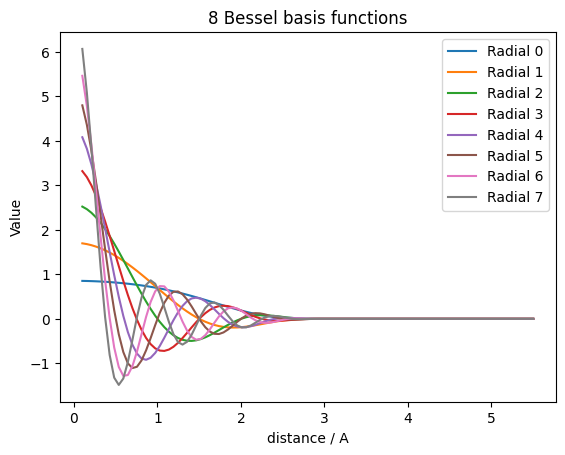

In [78]:
dists = torch.tensor(np.linspace(0.1, 5.5, 100), dtype=torch.get_default_dtype()).unsqueeze(-1)

radials = model.radial_embedding(dists, batch["node_attrs"], batch["edge_index"], model.atomic_numbers)

for i in range(radials.shape[1]):
    plt.plot(dists, radials[:, i], label=f'Radial {i}')

# Add title, labels, and legend
plt.title("8 Bessel basis functions")
plt.xlabel("distance / A")
plt.ylabel("Value")
plt.legend()

# Display the plot
plt.show()

The radial basis is evaluated on the distances and is stored as edge features to be used later in the interaction block to compute the 1-particle basis.

In [79]:
edge_feats = model.radial_embedding(lengths, batch["node_attrs"], batch["edge_index"], model.atomic_numbers)
print("The edge features have shape (num_edges, num_radials)")
print(edge_feats.shape)

The edge features have shape (num_edges, num_radials)
torch.Size([4, 8])


### Node Embedding
Next we look at the `LinearNodeEmbeddingBlock` implemented in `mace/modules/blocks.py`

```py
class LinearNodeEmbeddingBlock(torch.nn.Module):
```

The node attributes are integers that correspond to the chemical elements. They are prepared during the data loading (input preparation) phase using the `z_table` specifying the model chemical elements. This is part of creating the batch object.

In [80]:
atomic_numbers = [8, 1, 1]  # the atomic numbers of the structure evaluated
indices = tools.utils.atomic_numbers_to_indices(atomic_numbers, z_table=z_table)
node_attrs = tools.torch_tools.to_one_hot(
            torch.tensor(indices, dtype=torch.long).unsqueeze(-1),
            num_classes=len(z_table),
        )
print(node_attrs)  # node attributes are the one hot encoding of the chemical  elements of each node

tensor([[0., 1.],
        [1., 0.],
        [1., 0.]])


In [81]:
model.node_embedding  # node embedding block of the model mapping the one-hot (2 dimensional because we have two chemical elements) to 32 channels using a learnable linear

LinearNodeEmbeddingBlock(
  (linear): Linear(2x0e -> 4x0e | 8 weights)
)

In [83]:
print("Weights are internally flattened and have a shape",
      model.node_embedding.linear.__dict__['_parameters']['weight'].shape)

print("\nThis corresponds to (num_chemical_elements, num_channels) learnable embeddings for each chemical element with shape:",
      model.node_embedding.linear.__dict__['_parameters']['weight'].reshape((2, 4)).shape)

Weights are internally flattened and have a shape torch.Size([8])

This corresponds to (num_chemical_elements, num_channels) learnable embeddings for each chemical element with shape: torch.Size([2, 4])


Next is the implementation of forming the intial node embeddings:

 $h_{i,k00}^{(0)} = \sum_z W_{kz} \delta_{zz_{i}}$

In [84]:
# In MACE we create the initial node features using this block:
node_feats = model.node_embedding(node_attrs)

# chemical elements are embedded into 32 channels of the model. These 32 numbers are the initial node features.
print("The node embedding block returns (num_atoms, num_channels) shaped tensor:", node_feats.shape)

The node embedding block returns (num_atoms, num_channels) shaped tensor: torch.Size([3, 4])


These initial node features will be used in the 1-particle basis of the interaction block.

In [142]:
model.atomic_energies_fn

AtomicEnergiesBlock(energies=[[-1.0000, -3.0000]])

## Interaction Blocks

The interaction blocks is used to create the **sketched** atomic basis $A_{iklm}$ for each atoms $i$ at each layer $s$.
Different interaction blocks can be used, but the two defaults are the   **RealAgnosticInteractionBlock** for the first layer and **RealAgnosticResidualInteractionBlock** implemented in `mace/modules/blocks.py`.
```py
class RealAgnosticResidualInteractionBlock()
```
Here we will analyse the interaction block used in the model at the first layer.

In [85]:
print(model.interactions[0])

RealAgnosticResidualInteractionBlock(
  (linear_up): Linear(4x0e -> 4x0e | 16 weights)
  (conv_tp): TensorProduct(4x0e x 1x0e+1x1o+1x2e -> 4x0e+4x1o+4x2e | 12 paths | 12 weights)
  (conv_tp_weights): FullyConnectedNet[8, 64, 64, 64, 12]
  (linear): Linear(4x0e+4x1o+4x2e -> 4x0e+4x1o+4x2e | 48 weights)
  (skip_tp): FullyConnectedTensorProduct(4x0e x 2x0e -> 4x0e+4x1o | 32 paths | 32 weights)
  (reshape): reshape_irreps()
)


It has four steps:
1. Linearly mixing the incoming node features: $\bar{h}^{(s)}_{i,kl_2m_2} = \sum_{\tilde{k}} W_{k\tilde{k}l_2}^{(s)} h^{(s)}_{i,\tilde{k}l_2m_2}$

In [86]:
print(model.interactions[0].linear_up)
node_feats = model.interactions[0].linear_up(node_feats)
print(node_feats.shape)

Linear(4x0e -> 4x0e | 16 weights)
torch.Size([3, 4])


2. Construct the learnable radial basis using the Bessel Basis and the radial **MLP**:
$    R_{k \eta_{1} l_{1}l_{2} l_{3}}^{(s)}(r_{ij}) =   {\rm MLP}\left( \left\{ {j_0^n} (r_{ij})\right\}_{n}\right)$


In [87]:
print(model.interactions[0].conv_tp_weights)
# We go from 8 Bessel channels, to three layers of 64 channels, to 224 channels representing all the paths in the tensor product of the two irreps
tp_weights = model.interactions[0].conv_tp_weights(edge_feats)
print(tp_weights.shape)

FullyConnectedNet[8, 64, 64, 64, 12]
torch.Size([4, 12])


At this point it is possible to plot the MACE learnt radial functions (Note that here the model is untrained)

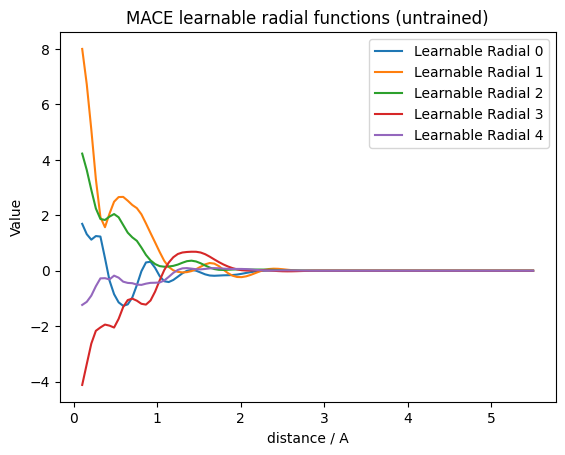

In [88]:
dists = torch.tensor(np.linspace(0.1, 5.5, 100), dtype=torch.get_default_dtype()).unsqueeze(-1)

edge_feats_scan = model.radial_embedding(dists, batch["node_attrs"], batch["edge_index"], model.atomic_numbers)

tp_weights_scan = model.interactions[0].conv_tp_weights(edge_feats_scan).detach().numpy()

num_basis_to_print = 5
for i in range(num_basis_to_print):
    plt.plot(dists, tp_weights_scan[:, i], label=f'Learnable Radial {i}')

# Add title, labels, and legend
plt.title("MACE learnable radial functions (untrained)")
plt.xlabel("distance / A")
plt.ylabel("Value")
plt.legend()

# Display the plot
plt.show()

3. The formation of the one particle basis  $\phi_{ij,k \eta_{1} l_{3}m_{3}}^{(s)} = \sum_{l_1l_2m_1m_2} C_{\eta_1,l_1m_1l_2m_2}^{l_3m_3}R_{k \eta_{1}l_{1}l_{2}l_{3}}^{(s)}(r_{ij})  Y^{m_{1}}_{l_{1}} (\boldsymbol{\hat{r}}_{ij}) \bar{h}^{(s)}_{j,kl_2m_2}$.

In [89]:
print(model.interactions[0].conv_tp)
sender, receiver = batch["edge_index"] # use the graph to get the sender and receiver indices
mji = model.interactions[0].conv_tp(
            node_feats[sender], edge_attrs, tp_weights
        )
print("The first dimension is the number of edges, highlighted by the ij in the variable name", mji.shape)
print(f"The second dimension is num_channels * num_paths dimensional * (l3 + 1)**2, in this case: {mji.shape[-1]} = 32 * {tp_weights.shape[-1] // 32} * 9 ", )

TensorProduct(4x0e x 1x0e+1x1o+1x2e -> 4x0e+4x1o+4x2e | 12 paths | 12 weights)
The first dimension is the number of edges, highlighted by the ij in the variable name torch.Size([4, 36])
The second dimension is num_channels * num_paths dimensional * (l3 + 1)**2, in this case: 36 = 32 * 0 * 9 


4. The sum over the neighbors of atom $i$ to form the atomic basis $\sum_{j \in \mathcal{N}(i)} \phi_{ij,k \eta_{1} l_{3}m_{3}}^{(s)}$.

In [90]:
from mace.tools.scatter import scatter_sum
message = scatter_sum(
            src=mji, index=receiver, dim=0, dim_size=node_feats.shape[0]
        )
print("The messages have first dimension corresponding to the nodes i:", message.shape)

The messages have first dimension corresponding to the nodes i: torch.Size([3, 36])


5. The linear sketching that mixes the channels to form  $A_{i,kl_{3}m_{3}}^{(s)} = \sum_{\tilde{k}, \eta_{1}} W_{k \tilde{k} \eta_{1}l_{3}}^{(s)}\sum_{j \in \mathcal{N}(i)}  \phi_{ij,\tilde{k} \eta_{1} l_{3}m_{3}}^{(s)}$.
    
    For the first layer **only**, these weights are species dependent (hence the last module called skip_tp) but we will show the default case here:

In [91]:
node_feats = model.interactions[0].linear(message)
print("This step leaves the shape unchanged:", message.shape)

This step leaves the shape unchanged: torch.Size([3, 36])


## Equivariant Symmetric Product Basis

$$  {m}_i^{(t)} =
  \sum_j {u}_1 \left( \sigma_i^{(t)}; \sigma_j^{(t)} \right)
  + \sum_{j_1, j_2} {u}_2 \left(\sigma_i^{(t)}; \sigma_{j_1}^{(t)}, \sigma_{j_2}^{(t)} \right)
  + \dots +
  \sum_{j_1, \dots, j_{\nu}} {u}_{\nu} \left( \sigma_i^{(t)}; \sigma_{j_1}^{(t)}, \dots, \sigma_{j_{\nu}}^{(t)} \right)$$

The equivariant symmetric product is implemented in `mace/modules/symmetric_contraction.py` and is called **SymmetricContraction**.

```py
class SymmetricContraction(CodeGenMixin, torch.nn.Module):
```

The key operation of MACE is the efficient construction of higher order features from the ${A}_{i}^{(t)}$-features.
This is achieved by first forming tensor products of the features, and then symmetrising:

$$
  {B}^{(t)}_{i,\eta_{\nu} k LM}
  = \sum_{{l}{m}} \mathcal{C}^{LM}_{\eta_{\nu}, l m} \prod_{\xi = 1}^{\nu} A_{i,k l_\xi  m_\xi}^{(t)}, \quad {l}{m} = (l_{1}m_{1},\dots,l_{\nu}m_{\nu})
  $$

And then summing the basis with learnable weights to form the many body equivariant messages:

$$m_{i,k LM}^{(t)} =  \sum_{\nu} \sum_{\eta_{\nu}} W_{z_{i}k L, \eta_{\nu}}^{(t)} {B}^{(t)}_{i,\eta_{\nu} k LM}$$


In [92]:
print(model.products[0].symmetric_contractions)

SymmetricContraction(
  (contractions): ModuleList(
    (0): Contraction(
      (contractions_weighting): ModuleList(
        (0-1): 2 x GraphModule()
      )
      (contractions_features): ModuleList(
        (0-1): 2 x GraphModule()
      )
      (weights): ParameterList(
          (0): Parameter containing: [torch.float32 of size 2x3x4]
          (1): Parameter containing: [torch.float32 of size 2x1x4]
      )
      (graph_opt_main): GraphModule()
    )
    (1): Contraction(
      (contractions_weighting): ModuleList(
        (0-1): 2 x GraphModule()
      )
      (contractions_features): ModuleList(
        (0-1): 2 x GraphModule()
      )
      (weights): ParameterList(
          (0): Parameter containing: [torch.float32 of size 2x4x4]
          (1): Parameter containing: [torch.float32 of size 2x1x4]
      )
      (graph_opt_main): GraphModule()
    )
  )
)


In [93]:
node_feats = model.interactions[0].reshape(message)
print("Input shape", node_feats.shape)
node_feats = model.products[0](node_feats=node_feats, sc=None, node_attrs=batch["node_attrs"])
print("Output shape", message.shape)

Input shape torch.Size([3, 4, 9])
Output shape torch.Size([3, 36])


Each **Contraction** submodules of the **SymmetricContraction** module is responsible for the construction of the basis for a given equivariant output $LM$.
One can print the shape of the different weights $W_{z_{i}k L, \eta_{\nu}}^{(t)}$ stored in this submodule. These weights have shape $[N_{\text{elements}},N_{\text{path}},N_{\text{channels}}]$. The number $N_{\text{path}}$ is a function of the output $LM$ and the correlation order $\nu$, and $l_{\text{max}}$.

In [94]:
print("nu = 3 :",model.products[0].symmetric_contractions.contractions[0].__dict__["_parameters"]["weights_max"].shape)
print("nu = 2 :",model.products[0].symmetric_contractions.contractions[0].weights[0].shape)
print("nu = 1 :",model.products[0].symmetric_contractions.contractions[0].weights[1].shape)

nu = 3 : torch.Size([2, 11, 4])
nu = 2 : torch.Size([2, 3, 4])
nu = 1 : torch.Size([2, 1, 4])


## MACE readout

To create the output of the model we use the node features from all layers $s$:

\begin{equation}
    \mathcal{R}^{(s)} \left( \boldsymbol{h}_i^{(s)} \right) =
    \begin{cases}
      \sum_{k}W^{(s)}_{k}h^{(s)}_{i,k00}     & \text{if} \;\; 1 < s < S \\[13pt]
      {\rm MLP} \left( \left\{ h^{(s)}_{i,k00} \right\}_k \right)  &\text{if} \;\; s = S
    \end{cases}
\end{equation}

The first linear readout is implemented in

```py
class LinearReadoutBlock(torch.nn.Module):
```

In our example case this maps the 32 dimensional $h^{(1)}_{i,k00}$, the invariant part os the node features after the first interaction to the first term in the aotmic site energy:

In [95]:
print(model.readouts[0])

LinearReadoutBlock(
  (linear): Linear(4x0e+4x1o -> 1x0e | 4 weights)
)


In [96]:
node_energies = model.readouts[0](node_feats).squeeze(-1)

The last layer readout block is a 1 hidden layer Multi Layer Percptron (MLP):

```py
class NonLinearReadoutBlock(torch.nn.Module):
```

In [97]:
print(model.readouts[1])

NonLinearReadoutBlock(
  (linear_1): Linear(4x0e -> 2x0e | 8 weights)
  (non_linearity): Activation [x] (2x0e -> 2x0e)
  (linear_2): Linear(2x0e -> 1x0e | 2 weights)
)


It is also possible to have equivariant readouts. This can be achieved by using Gated non-linearities. See as an example:

```py
class NonLinearDipoleReadoutBlock(torch.nn.Module):
```

These readouts are formed for each node in the batch. To turn them into a graph level readout we use a scatter sum operation which sums the node energies for each graph (separate chemical strucutre) in the batch. This is followed by summing the atomic energy and 1-st, 2nd etc. layer contributions to form the final model output.

In [98]:
energy = scatter_sum(
                src=node_energies, index=batch["batch"], dim=-1, dim_size=batch.num_graphs
            )  # [n_graphs,]
# in the code this step is done for each layer followed by summing the layer-wise output
print("Energy:",energy)

Energy: tensor([0.2974], grad_fn=<ScatterAddBackward0>)


# MACE internal

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from scipy.spatial.transform import Rotation

from e3nn import o3

from mace import data, modules, tools
from mace.tools import torch_geometric

import ase.io
from ase.visualize import view

import warnings
warnings.filterwarnings('ignore')
torch.set_default_dtype(torch.float32)

In [97]:
from typing import Any, Callable, Dict, List, Optional, Type, Union

import numpy as np
import torch
from e3nn import o3
from e3nn.util.jit import compile_mode

from mace.data import AtomicData
from mace.modules.radial import ZBLBasis
from mace.tools.scatter import scatter_sum

from mace.modules.blocks import (
    AtomicEnergiesBlock,
    EquivariantProductBasisBlock,
    InteractionBlock,
    LinearDipoleReadoutBlock,
    LinearNodeEmbeddingBlock,
    LinearReadoutBlock,
    NonLinearDipoleReadoutBlock,
    NonLinearReadoutBlock,
    RadialEmbeddingBlock,
    ScaleShiftBlock,
)
from mace.modules.utils import (
    compute_fixed_charge_dipole,
    compute_forces,
    get_edge_vectors_and_lengths,
    get_outputs,
    get_symmetric_displacement,
)

# pylint: disable=C0302


@compile_mode("script")
class MACE(torch.nn.Module):
    def __init__(
        self,
        r_max: float,
        num_bessel: int,
        num_polynomial_cutoff: int,
        max_ell: int,
        interaction_cls: Type[InteractionBlock],
        interaction_cls_first: Type[InteractionBlock],
        num_interactions: int,
        num_elements: int,
        hidden_irreps: o3.Irreps,
        MLP_irreps: o3.Irreps,
        atomic_energies: np.ndarray,
        avg_num_neighbors: float,
        atomic_numbers: List[int],
        correlation: Union[int, List[int]],
        gate: Optional[Callable],
        pair_repulsion: bool = False,
        distance_transform: str = "None",
        radial_MLP: Optional[List[int]] = None,
        radial_type: Optional[str] = "bessel",
        heads: Optional[List[str]] = None,
    ):
        super().__init__()
        self.register_buffer(
            "atomic_numbers", torch.tensor(atomic_numbers, dtype=torch.int64)
        )
        self.register_buffer(
            "r_max", torch.tensor(r_max, dtype=torch.get_default_dtype())
        )
        self.register_buffer(
            "num_interactions", torch.tensor(num_interactions, dtype=torch.int64)
        )
        if heads is None:
            heads = ["default"]
        self.heads = heads
        if isinstance(correlation, int):
            correlation = [correlation] * num_interactions
        # Embedding
        node_attr_irreps = o3.Irreps([(num_elements, (0, 1))])
        node_feats_irreps = o3.Irreps([(hidden_irreps.count(o3.Irrep(0, 1)), (0, 1))])
        self.node_embedding = LinearNodeEmbeddingBlock(
            irreps_in=node_attr_irreps, irreps_out=node_feats_irreps
        )
        self.radial_embedding = RadialEmbeddingBlock(
            r_max=r_max,
            num_bessel=num_bessel,
            num_polynomial_cutoff=num_polynomial_cutoff,
            radial_type=radial_type,
            distance_transform=distance_transform,
        )
        edge_feats_irreps = o3.Irreps(f"{self.radial_embedding.out_dim}x0e")
        if pair_repulsion:
            self.pair_repulsion_fn = ZBLBasis(r_max=r_max, p=num_polynomial_cutoff)
            self.pair_repulsion = True

        sh_irreps = o3.Irreps.spherical_harmonics(max_ell)
        num_features = hidden_irreps.count(o3.Irrep(0, 1))
        interaction_irreps = (sh_irreps * num_features).sort()[0].simplify()
        self.spherical_harmonics = o3.SphericalHarmonics(
            sh_irreps, normalize=True, normalization="component"
        )
        if radial_MLP is None:
            radial_MLP = [64, 64, 64]
        # Interactions and readout
        self.atomic_energies_fn = AtomicEnergiesBlock(atomic_energies)

        inter = interaction_cls_first(
            node_attrs_irreps=node_attr_irreps,
            node_feats_irreps=node_feats_irreps,
            edge_attrs_irreps=sh_irreps,
            edge_feats_irreps=edge_feats_irreps,
            target_irreps=interaction_irreps,
            hidden_irreps=hidden_irreps,
            avg_num_neighbors=avg_num_neighbors,
            radial_MLP=radial_MLP,
        )
        self.interactions = torch.nn.ModuleList([inter])

        # Use the appropriate self connection at the first layer for proper E0
        use_sc_first = False
        if "Residual" in str(interaction_cls_first):
            use_sc_first = True

        node_feats_irreps_out = inter.target_irreps
        prod = EquivariantProductBasisBlock(
            node_feats_irreps=node_feats_irreps_out,
            target_irreps=hidden_irreps,
            correlation=correlation[0],
            num_elements=num_elements,
            use_sc=use_sc_first,
        )
        self.products = torch.nn.ModuleList([prod])

        self.readouts = torch.nn.ModuleList()
        self.readouts.append(
            LinearReadoutBlock(hidden_irreps, o3.Irreps(f"{len(heads)}x0e"))
        )

        for i in range(num_interactions - 1):
            if i == num_interactions - 2:
                hidden_irreps_out = str(
                    hidden_irreps[0]
                )  # Select only scalars for last layer
            else:
                hidden_irreps_out = hidden_irreps
            inter = interaction_cls(
                node_attrs_irreps=node_attr_irreps,
                node_feats_irreps=hidden_irreps,
                edge_attrs_irreps=sh_irreps,
                edge_feats_irreps=edge_feats_irreps,
                target_irreps=interaction_irreps,
                hidden_irreps=hidden_irreps_out,
                avg_num_neighbors=avg_num_neighbors,
                radial_MLP=radial_MLP,
            )
            self.interactions.append(inter)
            prod = EquivariantProductBasisBlock(
                node_feats_irreps=interaction_irreps,
                target_irreps=hidden_irreps_out,
                correlation=correlation[i + 1],
                num_elements=num_elements,
                use_sc=True,
            )
            self.products.append(prod)
            if i == num_interactions - 2:
                self.readouts.append(
                    NonLinearReadoutBlock(
                        hidden_irreps_out,
                        (len(heads) * MLP_irreps).simplify(),
                        gate,
                        o3.Irreps(f"{len(heads)}x0e"),
                        len(heads),
                    )
                )
            else:
                self.readouts.append(
                    LinearReadoutBlock(hidden_irreps, o3.Irreps(f"{len(heads)}x0e"))
                )

    def forward(
        self,
        data: Dict[str, torch.Tensor],
        training: bool = False,
        compute_force: bool = True,
        compute_virials: bool = False,
        compute_stress: bool = False,
        compute_displacement: bool = False,
        compute_hessian: bool = False,
    ) -> Dict[str, Optional[torch.Tensor]]:
        # Setup
        data["node_attrs"].requires_grad_(True)
        data["positions"].requires_grad_(True)

        print(f"data['node_attrs']: {data['node_attrs'].shape}, {data['node_attrs'].dtype}\n{data['node_attrs']}", end='\n-----------------------------------------------------------\n')
        print(f"data['positions']: {data['positions'].shape}, {data['positions'].dtype}\n{data['positions']}" , end='\n-----------------------------------------------------------\n')

        num_atoms_arange = torch.arange(data["positions"].shape[0])
        num_graphs = data["ptr"].numel() - 1

        print(f"num_atoms_arange: {num_atoms_arange.shape}\n{num_atoms_arange}", end='\n-----------------------------------------------------------\n')
        print(f"num_graphs:{num_graphs}", end='\n-----------------------------------------------------------\n')

        node_heads = (
            data["head"][data["batch"]]
            if "head" in data
            else torch.zeros_like(data["batch"])
        )
        displacement = torch.zeros(
            (num_graphs, 3, 3),
            dtype=data["positions"].dtype,
            device=data["positions"].device,
        )

        print(f"node_heads:{node_heads.shape}\n{node_heads}", end='\n-----------------------------------------------------------\n')
        print(f"displacement:{displacement.shape}\n{displacement}", end='\n-----------------------------------------------------------\n')
        if compute_virials or compute_stress or compute_displacement:
            (
                data["positions"],
                data["shifts"],
                displacement,
            ) = get_symmetric_displacement(
                positions=data["positions"],
                unit_shifts=data["unit_shifts"],
                cell=data["cell"],
                edge_index=data["edge_index"],
                num_graphs=num_graphs,
                batch=data["batch"],
            )

        # Atomic energies
        node_e0 = self.atomic_energies_fn(data["node_attrs"])[
            num_atoms_arange, node_heads
        ]
        e0 = scatter_sum(
            src=node_e0, index=data["batch"], dim=0, dim_size=num_graphs
        )  # [n_graphs, n_heads]
        print(f"self.atomic_energies_fn(data['node_attrs'])={self.atomic_energies_fn(data['node_attrs']).shape}\n{self.atomic_energies_fn(data['node_attrs'])}", end='\n-----------------------------------------------------------\n')
        print(f"node_e0:{node_e0.shape}\n{node_e0}", end='\n-----------------------------------------------------------\n')
        print(f"e0:{e0.shape}\n{e0}", end='\n-----------------------------------------------------------\n')

        # Embeddings
        node_feats = self.node_embedding(data["node_attrs"])
        vectors, lengths = get_edge_vectors_and_lengths(
            positions=data["positions"],
            edge_index=data["edge_index"],
            shifts=data["shifts"],
        )
        edge_attrs = self.spherical_harmonics(vectors)
        edge_feats = self.radial_embedding(
            lengths, data["node_attrs"], data["edge_index"], self.atomic_numbers
        )

        print(f"node_feats:{node_feats.shape}\n{node_feats}", end='\n-----------------------------------------------------------\n')
        print(f"vectors:{vectors.shape}\n{vectors}", end='\n-----------------------------------------------------------\n')
        print(f"lengths:{lengths.shape}\n{lengths}", end='\n-----------------------------------------------------------\n')
        print(f"edge_attrs (sph):{edge_attrs.shape}\n{edge_attrs}", end='\n-----------------------------------------------------------\n')
        print(f"edge_feats (bess):{edge_feats.shape}\n{edge_feats}", end='\n-----------------------------------------------------------\n')

        if hasattr(self, "pair_repulsion"):
            print("had pair repulsion")
            pair_node_energy = self.pair_repulsion_fn(
                lengths, data["node_attrs"], data["edge_index"], self.atomic_numbers
            )
            pair_energy = scatter_sum(
                src=pair_node_energy, index=data["batch"], dim=-1, dim_size=num_graphs
            )  # [n_graphs,]
        else:
            print("no pair repulsion")
            pair_node_energy = torch.zeros_like(node_e0)
            pair_energy = torch.zeros_like(e0)

        print(f"pair_node_energy:{pair_node_energy.shape}\n{pair_node_energy}", end='\n-----------------------------------------------------------\n')
        print(f"pair_energy:{pair_energy.shape}\n{pair_energy}", end='\n-----------------------------------------------------------\n')

        # Interactions
        energies = [e0, pair_energy]
        node_energies_list = [node_e0, pair_node_energy]
        node_feats_list = []

        print("before interactions start: ")
        print(f"energies:{energies}", end='\n-----------------------------------------------------------\n')
        print(f"node_energies_list:{node_energies_list}", end='\n-----------------------------------------------------------\n')
        print(f"node_feats_list:{node_feats_list}", end='\n-----------------------------------------------------------\n')

        i = 0 
        for interaction, product, readout in zip(
            self.interactions, self.products, self.readouts
        ):
            print(f"*****************for loop i={i}*******************")
            i+=1
            node_feats, sc = interaction(
                node_attrs=data["node_attrs"],
                node_feats=node_feats,
                edge_attrs=edge_attrs,
                edge_feats=edge_feats,
                edge_index=data["edge_index"],
            )
            print(f"#####after Interaction:")
            print(f"node_feats:{node_feats.shape}\n{node_feats}", end='\n-----------------------------------------------------------\n')
            print(f"sc:{sc.shape}\n{sc}", end='\n-----------------------------------------------------------\n')

            node_feats = product(
                node_feats=node_feats,
                sc=sc,
                node_attrs=data["node_attrs"],
            )

            print(f"#####after Product:")
            print(f"node_feats:{node_feats.shape}\n{node_feats}", end='\n-----------------------------------------------------------\n')

            node_feats_list.append(node_feats)
            node_energies = readout(node_feats, node_heads)[
                num_atoms_arange, node_heads
            ]  # [n_nodes, len(heads)]

            print(f"#####after readout:")
            print(f"readout_output:{readout(node_feats, node_heads).shape}\n{readout(node_feats, node_heads)}", end='\n-----------------------------------------------------------\n')
            print(f"node_energies:{node_energies.shape}\n{node_energies}", end='\n-----------------------------------------------------------\n')

            energy = scatter_sum(
                src=node_energies,
                index=data["batch"],
                dim=0,
                dim_size=num_graphs,
            )  # [n_graphs,]
            print(f"#####after scatter sum:")
            print(f"energy:{energy.shape}\n{energy}", end='\n-----------------------------------------------------------\n')
            energies.append(energy)
            node_energies_list.append(node_energies)


        print('**********************************************')
        print("After interactions end: ")
        print(f"energies:{energies}", end='\n-----------------------------------------------------------\n')
        print(f"node_energies_list:{node_energies_list}", end='\n-----------------------------------------------------------\n')
        print(f"node_feats_list:{node_feats_list}", end='\n-----------------------------------------------------------\n')

        # Concatenate node features
        node_feats_out = torch.cat(node_feats_list, dim=-1)

        # Sum over energy contributions
        contributions = torch.stack(energies, dim=-1)
        total_energy = torch.sum(contributions, dim=-1)  # [n_graphs, ]
        node_energy_contributions = torch.stack(node_energies_list, dim=-1)
        node_energy = torch.sum(node_energy_contributions, dim=-1)  # [n_nodes, ]

        print(f"contributions:{contributions.shape}\n{contributions}", end='\n-----------------------------------------------------------\n')
        print(f"total_energy:{total_energy.shape}\n{total_energy}", end='\n-----------------------------------------------------------\n')
        print(f"node_energy_contributions:{node_energy_contributions.shape}\n{node_energy_contributions}", end='\n-----------------------------------------------------------\n')
        print(f"node_energy:{node_energy.shape}\n{node_energy}", end='\n-----------------------------------------------------------\n')

        # Outputs
        forces, virials, stress, hessian = get_outputs(
            energy=total_energy,
            positions=data["positions"],
            displacement=displacement,
            cell=data["cell"],
            training=training,
            compute_force=compute_force,
            compute_virials=compute_virials,
            compute_stress=compute_stress,
            compute_hessian=compute_hessian,
        )

        print(f"forces:{forces.shape}\n{forces}", end='\n-----------------------------------------------------------\n')

        return {
            "energy": total_energy,
            "node_energy": node_energy,
            "contributions": contributions,
            "forces": forces,
            "virials": virials,
            "stress": stress,
            "displacement": displacement,
            "hessian": hessian,
            "node_feats": node_feats_out,
        }


In [45]:
molecule_list = ase.io.read('data/solvent_rotated.xyz', index='0:10')

Rcut = 3.0 # cutoff radius
z_table = tools.AtomicNumberTable([1, 6, 8])

config_list = [data.Configuration(
    atomic_numbers=single_molecule.numbers,
    positions=single_molecule.positions
) for single_molecule in molecule_list]

# we handle configurations using the AtomicData class
dataset = [data.AtomicData.from_config(config, z_table=z_table, cutoff=Rcut) for config in config_list]

data_loader = torch_geometric.dataloader.DataLoader(dataset=dataset,
                                                    batch_size=3,)


In [46]:
batch = next(iter(data_loader))

In [47]:
type(batch)

mace.tools.torch_geometric.batch.Batch

In [48]:
batch.keys

['edge_index',
 'batch',
 'ptr',
 'positions',
 'shifts',
 'unit_shifts',
 'cell',
 'node_attrs',
 'weight',
 'head',
 'energy_weight',
 'forces_weight',
 'stress_weight',
 'virials_weight']

In [58]:
z_table = tools.AtomicNumberTable([1,6,8])
atomic_energies = np.array([-1.0, -3.0, -5.0], dtype=np.float32)
cutoff = 3

model_config = dict(
        num_elements=3,  # number of chemical elements
        atomic_energies=atomic_energies,  # atomic energies used for normalisation
        avg_num_neighbors=8,  # avg number of neighbours of the atoms, used for internal normalisation of messages
        atomic_numbers=z_table.zs,  # atomic numbers, used to specify chemical element embeddings of the model
        r_max=cutoff,  # cutoff
        num_bessel=8,  # number of radial features
        num_polynomial_cutoff=6,  # smoothness of the radial cutoff
        max_ell=2,  # expansion order of spherical harmonic adge attributes
        num_interactions=2,  # number of layers, typically 2
        interaction_cls_first=modules.interaction_classes[
            "RealAgnosticResidualInteractionBlock"
        ],  # interation block of first layer
        interaction_cls=modules.interaction_classes[
            "RealAgnosticResidualInteractionBlock"
        ],  # interaction block of subsequent layers
        hidden_irreps=o3.Irreps("4x0e + 4x1o"),  # 4: number of embedding channels, 0e, 1o is specifying which equivariant messages to use. Here up to L_max=1
        correlation=3,  # correlation order of the messages (body order - 1)
        MLP_irreps=o3.Irreps("8x0e"),  # number of hidden dimensions of last layer readout MLP
        gate=torch.nn.functional.silu,  # nonlinearity used in last layer readout MLP
    )

mace_model = MACE(**model_config)

In [56]:
for key in batch.keys:
    print(f"{key}|{batch[key].shape}, {batch[key].dtype}\n{batch[key]}", end ='\n----------------------------------------------------------------------------------\n')

edge_index|torch.Size([2, 222]), torch.int64
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,
          2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
          4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  7,  8,  8,
          8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11,
         11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13,
         13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16,
         16, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 19,
         20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 23, 23,
         23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25,
         25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 28,
         28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31,
         31, 31, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 34, 34,

In [51]:
type(batch)

mace.tools.torch_geometric.batch.Batch

In [52]:
x = batch.to_dict()
type(x)

dict

In [53]:
x.keys()

dict_keys(['batch', 'cell', 'edge_index', 'energy_weight', 'forces_weight', 'head', 'node_attrs', 'positions', 'ptr', 'shifts', 'stress_weight', 'unit_shifts', 'virials_weight', 'weight'])

In [59]:
op = mace_model(x,training = True,
                compute_force = True,
                compute_virials = False,
                compute_stress = False,
                compute_displacement = False,
                compute_hessian = False,)
        

data['node_attrs']: torch.Size([36, 3]), torch.float32
tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], requires_grad=True)
-----------------------------------------------------------
data['positions']: torch.Size([36, 3]), torch.float32
tensor([[-0.0635, 

# multiple head

In [79]:
molecule_list = ase.io.read('data/solvent_rotated.xyz', index='0:10')

Rcut = 3.0 # cutoff radius
z_table = tools.AtomicNumberTable([1, 6, 8])
head = {0:"Default",1:"New"}
config_list = [data.Configuration(
    atomic_numbers=single_molecule.numbers,
    positions=single_molecule.positions,
    head=head[i%2] ) for i, single_molecule in enumerate(molecule_list)]

# we handle configurations using the AtomicData class
dataset = [data.AtomicData.from_config(config, z_table=z_table, cutoff=Rcut, heads=list(head.values())) for config in config_list]

data_loader = torch_geometric.dataloader.DataLoader(dataset=dataset,
                                                    batch_size=4,)


In [80]:
batch = next(iter(data_loader))

In [81]:
batch.keys

['edge_index',
 'batch',
 'ptr',
 'positions',
 'shifts',
 'unit_shifts',
 'cell',
 'node_attrs',
 'weight',
 'head',
 'energy_weight',
 'forces_weight',
 'stress_weight',
 'virials_weight']

In [98]:
z_table = tools.AtomicNumberTable([1,6,8])
atomic_energies = np.array([[-1.0, -3.0, -5.0],
                            [-2.0, -6.0, -10.0]], dtype=np.float32)
cutoff = 3

model_config = dict(
        num_elements=3,  # number of chemical elements
        atomic_energies=atomic_energies,  # atomic energies used for normalisation
        avg_num_neighbors=8,  # avg number of neighbours of the atoms, used for internal normalisation of messages
        atomic_numbers=z_table.zs,  # atomic numbers, used to specify chemical element embeddings of the model
        r_max=cutoff,  # cutoff
        num_bessel=8,  # number of radial features
        num_polynomial_cutoff=6,  # smoothness of the radial cutoff
        max_ell=2,  # expansion order of spherical harmonic adge attributes
        num_interactions=2,  # number of layers, typically 2
        interaction_cls_first=modules.interaction_classes[
            "RealAgnosticResidualInteractionBlock"
        ],  # interation block of first layer
        interaction_cls=modules.interaction_classes[
            "RealAgnosticResidualInteractionBlock"
        ],  # interaction block of subsequent layers
        hidden_irreps=o3.Irreps("4x0e + 4x1o"),  # 4: number of embedding channels, 0e, 1o is specifying which equivariant messages to use. Here up to L_max=1
        correlation=3,  # correlation order of the messages (body order - 1)
        MLP_irreps=o3.Irreps("8x0e"),  # number of hidden dimensions of last layer readout MLP
        gate=torch.nn.functional.silu,  # nonlinearity used in last layer readout MLP
        heads = list(head.values())
    )

mace_multihead_model = MACE(**model_config)

In [83]:
mace_model

MACE(
  (node_embedding): LinearNodeEmbeddingBlock(
    (linear): Linear(3x0e -> 4x0e | 12 weights)
  )
  (radial_embedding): RadialEmbeddingBlock(
    (bessel_fn): BesselBasis(r_max=3.0, num_basis=8, trainable=False)
    (cutoff_fn): PolynomialCutoff(p=6.0, r_max=3.0)
  )
  (spherical_harmonics): SphericalHarmonics()
  (atomic_energies_fn): AtomicEnergiesBlock(energies=[[-1.0000, -3.0000, -5.0000]])
  (interactions): ModuleList(
    (0): RealAgnosticResidualInteractionBlock(
      (linear_up): Linear(4x0e -> 4x0e | 16 weights)
      (conv_tp): TensorProduct(4x0e x 1x0e+1x1o+1x2e -> 4x0e+4x1o+4x2e | 12 paths | 12 weights)
      (conv_tp_weights): FullyConnectedNet[8, 64, 64, 64, 12]
      (linear): Linear(4x0e+4x1o+4x2e -> 4x0e+4x1o+4x2e | 48 weights)
      (skip_tp): FullyConnectedTensorProduct(4x0e x 3x0e -> 4x0e+4x1o | 48 paths | 48 weights)
      (reshape): reshape_irreps()
    )
    (1): RealAgnosticResidualInteractionBlock(
      (linear_up): Linear(4x0e+4x1o -> 4x0e+4x1o | 32 we

In [99]:
mace_multihead_model

MACE(
  (node_embedding): LinearNodeEmbeddingBlock(
    (linear): Linear(3x0e -> 4x0e | 12 weights)
  )
  (radial_embedding): RadialEmbeddingBlock(
    (bessel_fn): BesselBasis(r_max=3.0, num_basis=8, trainable=False)
    (cutoff_fn): PolynomialCutoff(p=6.0, r_max=3.0)
  )
  (spherical_harmonics): SphericalHarmonics()
  (atomic_energies_fn): AtomicEnergiesBlock(energies=[[-1.0000, -3.0000, -5.0000], [-2.0000, -6.0000, -10.0000]])
  (interactions): ModuleList(
    (0): RealAgnosticResidualInteractionBlock(
      (linear_up): Linear(4x0e -> 4x0e | 16 weights)
      (conv_tp): TensorProduct(4x0e x 1x0e+1x1o+1x2e -> 4x0e+4x1o+4x2e | 12 paths | 12 weights)
      (conv_tp_weights): FullyConnectedNet[8, 64, 64, 64, 12]
      (linear): Linear(4x0e+4x1o+4x2e -> 4x0e+4x1o+4x2e | 48 weights)
      (skip_tp): FullyConnectedTensorProduct(4x0e x 3x0e -> 4x0e+4x1o | 48 paths | 48 weights)
      (reshape): reshape_irreps()
    )
    (1): RealAgnosticResidualInteractionBlock(
      (linear_up): Linear(

In [89]:
for key in batch.keys:
    print(f"{key}|{batch[key].shape}, {batch[key].dtype}\n{batch[key]}", end ='\n----------------------------------------------------------------------------------\n')

edge_index|torch.Size([2, 296]), torch.int64
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,
          2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
          4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  7,  8,  8,
          8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11,
         11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13,
         13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16,
         16, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 19,
         20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 23, 23,
         23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25,
         25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 28,
         28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31,
         31, 31, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 34, 34,

In [100]:
op = mace_multihead_model(batch.to_dict(),training = True,
                compute_force = True,
                compute_virials = False,
                compute_stress = False,
                compute_displacement = False,
                compute_hessian = False,)

data['node_attrs']: torch.Size([48, 3]), torch.float32
tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],

In [105]:
op['node_energy'].shape

torch.Size([48])

In [103]:
op['node_feats'].shape

torch.Size([48, 20])

In [ ]:
@compile_mode("script")
class ScaleShiftMACE(MACE):
    def __init__(
        self,
        atomic_inter_scale: float,
        atomic_inter_shift: float,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.scale_shift = ScaleShiftBlock(
            scale=atomic_inter_scale, shift=atomic_inter_shift
        )

    def forward(
        self,
        data: Dict[str, torch.Tensor],
        training: bool = False,
        compute_force: bool = True,
        compute_virials: bool = False,
        compute_stress: bool = False,
        compute_displacement: bool = False,
        compute_hessian: bool = False,
    ) -> Dict[str, Optional[torch.Tensor]]:
        # Setup
        data["positions"].requires_grad_(True)
        data["node_attrs"].requires_grad_(True)
        num_graphs = data["ptr"].numel() - 1
        num_atoms_arange = torch.arange(data["positions"].shape[0])
        node_heads = (
            data["head"][data["batch"]]
            if "head" in data
            else torch.zeros_like(data["batch"])
        )
        displacement = torch.zeros(
            (num_graphs, 3, 3),
            dtype=data["positions"].dtype,
            device=data["positions"].device,
        )
        if compute_virials or compute_stress or compute_displacement:
            (
                data["positions"],
                data["shifts"],
                displacement,
            ) = get_symmetric_displacement(
                positions=data["positions"],
                unit_shifts=data["unit_shifts"],
                cell=data["cell"],
                edge_index=data["edge_index"],
                num_graphs=num_graphs,
                batch=data["batch"],
            )

        # Atomic energies
        node_e0 = self.atomic_energies_fn(data["node_attrs"])[
            num_atoms_arange, node_heads
        ]
        e0 = scatter_sum(
            src=node_e0, index=data["batch"], dim=0, dim_size=num_graphs
        )  # [n_graphs, num_heads]

        # Embeddings
        node_feats = self.node_embedding(data["node_attrs"])
        vectors, lengths = get_edge_vectors_and_lengths(
            positions=data["positions"],
            edge_index=data["edge_index"],
            shifts=data["shifts"],
        )
        edge_attrs = self.spherical_harmonics(vectors)
        edge_feats = self.radial_embedding(
            lengths, data["node_attrs"], data["edge_index"], self.atomic_numbers
        )
        if hasattr(self, "pair_repulsion"):
            pair_node_energy = self.pair_repulsion_fn(
                lengths, data["node_attrs"], data["edge_index"], self.atomic_numbers
            )
        else:
            pair_node_energy = torch.zeros_like(node_e0)
        # Interactions
        node_es_list = [pair_node_energy]
        node_feats_list = []
        for interaction, product, readout in zip(
            self.interactions, self.products, self.readouts
        ):
            node_feats, sc = interaction(
                node_attrs=data["node_attrs"],
                node_feats=node_feats,
                edge_attrs=edge_attrs,
                edge_feats=edge_feats,
                edge_index=data["edge_index"],
            )
            node_feats = product(
                node_feats=node_feats, sc=sc, node_attrs=data["node_attrs"]
            )
            node_feats_list.append(node_feats)
            node_es_list.append(
                readout(node_feats, node_heads)[num_atoms_arange, node_heads]
            )  # {[n_nodes, ], }

        # Concatenate node features
        node_feats_out = torch.cat(node_feats_list, dim=-1)
        # Sum over interactions
        node_inter_es = torch.sum(
            torch.stack(node_es_list, dim=0), dim=0
        )  # [n_nodes, ]
        node_inter_es = self.scale_shift(node_inter_es, node_heads)

        # Sum over nodes in graph
        inter_e = scatter_sum(
            src=node_inter_es, index=data["batch"], dim=-1, dim_size=num_graphs
        )  # [n_graphs,]

        # Add E_0 and (scaled) interaction energy
        total_energy = e0 + inter_e
        node_energy = node_e0 + node_inter_es
        forces, virials, stress, hessian = get_outputs(
            energy=inter_e,
            positions=data["positions"],
            displacement=displacement,
            cell=data["cell"],
            training=training,
            compute_force=compute_force,
            compute_virials=compute_virials,
            compute_stress=compute_stress,
            compute_hessian=compute_hessian,
        )
        output = {
            "energy": total_energy,
            "node_energy": node_energy,
            "interaction_energy": inter_e,
            "forces": forces,
            "virials": virials,
            "stress": stress,
            "hessian": hessian,
            "displacement": displacement,
            "node_feats": node_feats_out,
        }

        return output

# Training

In [1]:
import torch

In [2]:
node_es_list = []

for i in range(2):
    node_es_list.append(torch.randn(36))

In [3]:
node_es_list

[tensor([-0.5055,  0.7625, -1.3724,  0.0537,  0.1067,  1.1058, -2.5597,  1.1319,
         -0.6691, -0.0668, -0.4934, -0.5816,  1.5955,  0.6860,  2.0167,  1.7370,
         -1.8601,  0.5714, -0.2622, -1.4796,  0.1008, -1.1044, -1.0757, -0.4179,
         -0.8947,  0.4501, -0.4547, -0.7921, -0.0497,  0.2468, -0.3936,  0.2439,
          0.3426, -0.0817, -0.4302, -0.8538]),
 tensor([-1.0935,  1.5115,  1.2259,  1.0035, -0.6473, -1.1422,  1.3129,  1.9371,
          0.7604, -2.6563,  1.9928,  0.9563,  0.3718,  0.4193, -1.0971,  0.7818,
          0.0645,  1.6598, -1.1236,  0.2180, -0.2371,  0.9748,  1.5121,  0.0188,
         -1.6519, -0.0730,  0.5109,  0.2124, -1.4095,  0.6119,  0.5404, -0.0106,
         -1.7938, -0.4042,  0.8990, -1.0070])]

In [6]:
torch.sum(torch.stack(node_es_list, dim=0), dim=0).shape

torch.Size([36])

In [7]:
n_nodes = 5
num_interactions = 2

node_inter_energies = torch.randn(n_nodes, num_interactions)
node_inter_energies.shape

torch.Size([5, 2])

In [8]:
shifted_node_e0 = torch.randn(n_nodes,)
shifted_node_e0.shape

torch.Size([5])

In [12]:
torch.cat([shifted_node_e0.unsqueeze(1), node_inter_energies], dim=1).shape

torch.Size([5, 3])

In [13]:
shifted_node_e0.unsqueeze(1)

tensor([[-0.5385],
        [ 0.8596],
        [ 0.5011],
        [-0.7524],
        [-1.1382]])

In [14]:
node_inter_energies

tensor([[-0.0722, -0.8079],
        [-0.6569,  0.5402],
        [-0.5778,  0.9371],
        [-0.1033, -0.2543],
        [-0.3349,  2.8252]])

In [15]:
torch.cat([shifted_node_e0.unsqueeze(1), node_inter_energies], dim=1)

tensor([[-0.5385, -0.0722, -0.8079],
        [ 0.8596, -0.6569,  0.5402],
        [ 0.5011, -0.5778,  0.9371],
        [-0.7524, -0.1033, -0.2543],
        [-1.1382, -0.3349,  2.8252]])